In [ ]:
import os
import numpy as np
import tensorflow as tf
import datetime
import json
import hashlib
import matplotlib.pyplot as plt

# --- 1. Fija seed=42 ---
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
print(f"Semilla fijada en: {SEED}")

# --- 2. Registra Versiones (Manual para ENVIRONMENT.md y requirements.txt) ---
# Puedes obtener las versiones de Python y TensorFlow así:
import sys
print(f"Versión de Python: {sys.version}")
print(f"Versión de TensorFlow: {tf.__version__}")

# Para verificar GPU (si estás en Colab con GPU activada):
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

# Para 'env/ENVIRONMENT.md' (Crea este archivo manualmente en tu repo):
# Contenido de ENVIRONMENT.md:
"""
# Entorno de Ejecución

## Versiones
- Python: [Versión que te salga de `sys.version`]
- TensorFlow: [Versión que te salga de `tf.__version__`]
- NumPy: [Versión de `np.__version__`]
- Matplotlib: [Versión de `matplotlib.__version__`]

## Hardware
- GPU: [Detalles de la GPU si está disponible, e.g., 'NVIDIA Tesla T4' o 'No GPU']
- CPU: [Información básica de la CPU]

## Fecha de Generación
- [Fecha y hora actual]
"""

# Para 'env/requirements.txt' (ejecuta esto en una celda de Colab para generar un borrador,
# luego guárdalo en tu repo en env/requirements.txt):
# !pip freeze > requirements.txt
# ¡Importante! El comando anterior generará _todas_ las dependencias de Colab.
# Para un 'requirements.txt' más limpio y mínimo, copia manualmente las librerías principales
# que _tú_ usas:
"""
tensorflow==X.Y.Z
numpy==A.B.C
matplotlib==P.Q.R
"""
# Reemplaza X.Y.Z, A.B.C, P.Q.R con las versiones que te muestre 'pip freeze' o manualmente.

Semilla fijada en: 42
Versión de Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Versión de TensorFlow: 2.19.0
GPU disponible: []


'\ntensorflow==X.Y.Z\nnumpy==A.B.C\nmatplotlib==P.Q.R\n'

In [ ]:
# --- Carga CIFAR-10 ---
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(f"Forma original de x_train_full: {x_train_full.shape}")
print(f"Forma original de y_train_full: {y_train_full.shape}")
print(f"Forma original de x_test: {x_test.shape}")
print(f"Forma original de y_test: {y_test.shape}")

# --- Split estratificado 80/20 ---
from sklearn.model_selection import StratifiedShuffleSplit

# Asegúrate de que y_train_full sea 1D para StratifiedShuffleSplit
y_train_full_flat = y_train_full.flatten()

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for train_idx, valid_idx in splitter.split(x_train_full, y_train_full_flat):
    x_train, y_train = x_train_full[train_idx], y_train_full_flat[train_idx]
    x_valid, y_valid = x_train_full[valid_idx], y_train_full_flat[valid_idx]

print(f"\nForma de x_train (80%): {x_train.shape}")
print(f"Forma de y_train (80%): {y_train.shape}")
print(f"Forma de x_valid (20%): {x_valid.shape}")
print(f"Forma de y_valid (20%): {y_valid.shape}")
print(f"Forma de x_test: {x_test.shape}")
print(f"Forma de y_test: {y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Forma original de x_train_full: (50000, 32, 32, 3)
Forma original de y_train_full: (50000, 1)
Forma original de x_test: (10000, 32, 32, 3)
Forma original de y_test: (10000, 1)

Forma de x_train (80%): (40000, 32, 32, 3)
Forma de y_train (80%): (40000,)
Forma de x_valid (20%): (10000, 32, 32, 3)
Forma de y_valid (20%): (10000,)
Forma de x_test: (10000, 32, 32, 3)
Forma de y_test: (10000, 1)


In [ ]:
# --- Normaliza imágenes a [0,1] ---
x_train = x_train.astype('float32') / 255.0
x_valid = x_valid.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(f"\nRangos de valores de píxeles tras normalización:")
print(f"x_train min: {x_train.min()}, max: {x_train.max()}")
print(f"x_valid min: {x_valid.min()}, max: {x_valid.max()}")
print(f"x_test min: {x_test.min()}, max: {x_test.max()}")


# --- Convierte etiquetas a one-hot ---
NUM_CLASSES = 10
y_train_one_hot = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_valid_one_hot = tf.keras.utils.to_categorical(y_valid, NUM_CLASSES)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

print(f"\nForma de y_train_one_hot: {y_train_one_hot.shape}")
print(f"Forma de y_valid_one_hot: {y_valid_one_hot.shape}")
print(f"Forma de y_test_one_hot: {y_test_one_hot.shape}")


Rangos de valores de píxeles tras normalización:
x_train min: 0.0, max: 1.0
x_valid min: 0.0, max: 1.0
x_test min: 0.0, max: 1.0

Forma de y_train_one_hot: (40000, 10)
Forma de y_valid_one_hot: (10000, 10)
Forma de y_test_one_hot: (10000, 10)


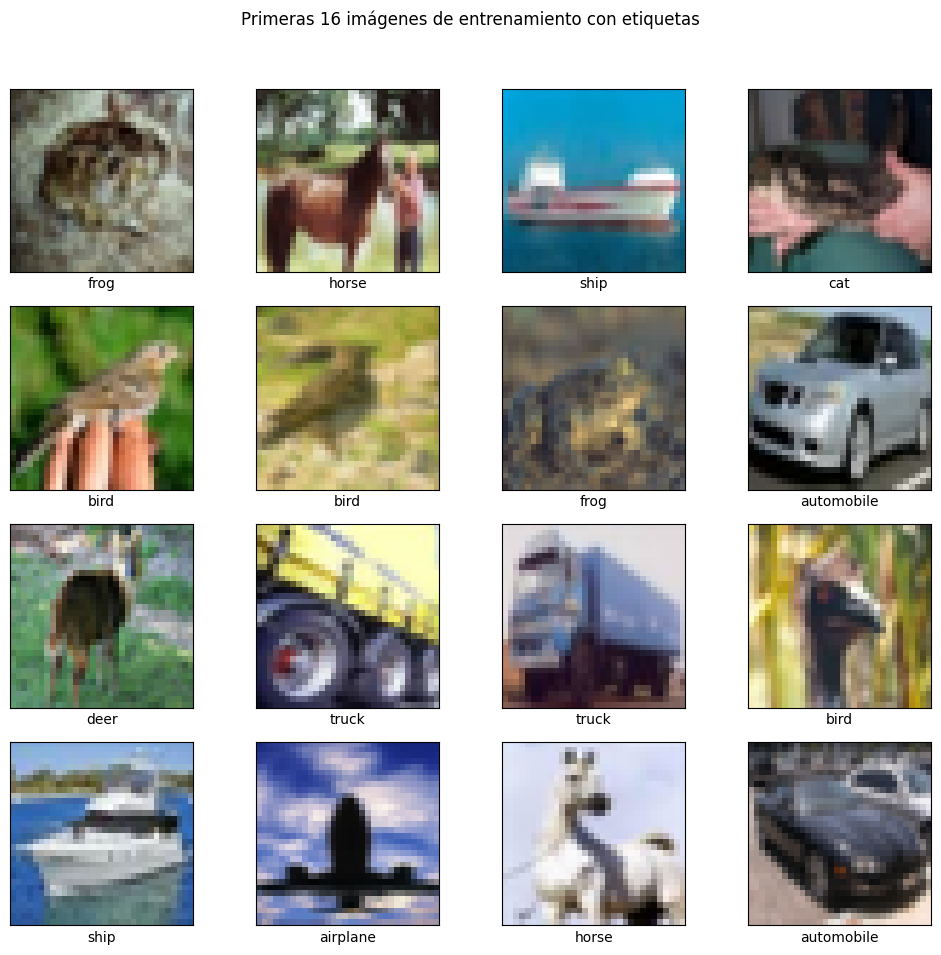

In [ ]:
# --- Visualiza 16 imágenes con nombre de clase ---
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    # Como y_train es 1D (no one-hot), usamos directamente el valor
    plt.xlabel(class_names[y_train[i]])
plt.suptitle("Primeras 16 imágenes de entrenamiento con etiquetas")
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta el layout para que el suptitle no se solape
plt.show()

In [ ]:
# --- R4 (HASH de datos): genera y guarda en results/data_meta.json ---
data_meta = {
    "x_train_shape": x_train.shape,
    "y_train_one_hot_shape": y_train_one_hot.shape,
    "x_valid_shape": x_valid.shape,
    "y_valid_one_hot_shape": y_valid_one_hot.shape,
    "x_test_shape": x_test.shape,
    "y_test_one_hot_shape": y_test_one_hot.shape,
    "timestamp": datetime.datetime.now().isoformat()
}

# Calcular SHA-256 de las primeras 1024 imágenes de x_train tras normalizar
# Convertimos a bytes para el hash
x_train_bytes = x_train[:1024].tobytes()
data_meta["x_train_1024_sha256_hash"] = hashlib.sha256(x_train_bytes).hexdigest()

# Crea la carpeta results si no existe
os.makedirs('results', exist_ok=True)
with open('results/data_meta.json', 'w') as f:
    json.dump(data_meta, f, indent=4)

print("\nMetadatos de datos guardados en results/data_meta.json")
print(json.dumps(data_meta, indent=4))


# --- R3: crea results/params.yaml con configuración inicial ---
import yaml

initial_params = {
    'seed': SEED,
    'model_configs': {}, # Aquí se añadirán los parámetros de cada modelo
    'training_configs': {
        'lr': 1e-3,
        'batch_size': 64,
        'epochs': 10,
        'augment': False,
        'l2_reg': 0.0,
        'dropout_rate': 0.0,
        'early_stopping': {'monitor': 'val_loss', 'patience': 5, 'restore_best_weights': True},
        'lr_scheduler': None # Se actualizará con ReduceLROnPlateau o CosineDecay
    },
    'data_augmentation': {
        'horizontal_flip': False,
        'rotation_factor': 0.0,
        'width_shift_factor': 0.0,
        'height_shift_factor': 0.0,
        'brightness_factor': 0.0
    },
    'best_model': {
        'name': 'None',
        'test_acc': 0.0,
        'commit_id': 'None',
        'timestamp': 'None'
    }
}

with open('results/params.yaml', 'w') as f:
    yaml.dump(initial_params, f, sort_keys=False)

print("\nConfiguración inicial guardada en results/params.yaml")


# --- R7 (opcional): prepara un smoke test de CI ---
# Esto es más conceptual. En un entorno real de CI, este script se ejecutaría.
# Aquí solo te muestro cómo sería el código para un smoke test muy básico.
# No lo ejecutes en tu Colab tal cual, es solo para entender el concepto.
"""
# Archivo: ci_smoke_test.py
import tensorflow as tf
import numpy as np

try:
    # Importar librerías clave
    _ = tf.keras.datasets.cifar10.load_data()
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    print("Smoke test: Importaciones y modelo mínimo OK.")
except Exception as e:
    print(f"Smoke test FALLÓ: {e}")
    exit(1)
"""
# Para que este smoke test se ejecute en tu CI, tendrías que configurarlo en tu plataforma (e.g., GitHub Actions).


Metadatos de datos guardados en results/data_meta.json
{
    "x_train_shape": [
        40000,
        32,
        32,
        3
    ],
    "y_train_one_hot_shape": [
        40000,
        10
    ],
    "x_valid_shape": [
        10000,
        32,
        32,
        3
    ],
    "y_valid_one_hot_shape": [
        10000,
        10
    ],
    "x_test_shape": [
        10000,
        32,
        32,
        3
    ],
    "y_test_one_hot_shape": [
        10000,
        10
    ],
    "timestamp": "2025-11-15T08:49:48.737290",
    "x_train_1024_sha256_hash": "382904eadd089d5da172d2bb9b34fd44965b4a079f0f0be722e706328df5118c"
}

Configuración inicial guardada en results/params.yaml


'\n# Archivo: ci_smoke_test.py\nimport tensorflow as tf\nimport numpy as np\n\ntry:\n    # Importar librerías clave\n    _ = tf.keras.datasets.cifar10.load_data()\n    model = tf.keras.Sequential([\n        tf.keras.layers.Flatten(input_shape=(32, 32, 3)),\n        tf.keras.layers.Dense(10, activation=\'softmax\')\n    ])\n    model.compile(optimizer=\'adam\', loss=\'categorical_crossentropy\')\n    print("Smoke test: Importaciones y modelo mínimo OK.")\nexcept Exception as e:\n    print(f"Smoke test FALLÓ: {e}")\n    exit(1)\n'

Por qué normalizar /255?
La normalización de los píxeles al rango [0, 1] es crucial para la estabilidad y velocidad de entrenamiento de las redes neuronales. Los optimizadores funcionan mejor con valores de entrada pequeños y consistentes. Evita que características con rangos más grandes dominen la función de pérdida y permite el uso de tasas de aprendizaje más grandes. Además, muchas funciones de activación (como sigmoid o tanh) son sensibles a la escala de la entrada.

Por qué estratificar aquí y no al final?
Se estratifica en el momento de dividir los datos (x_train_full, y_train_full) en conjuntos de entrenamiento (x_train, y_train) y validación (x_valid, y_valid). Estratificar significa que la proporción de cada clase se mantiene igual en los conjuntos de entrenamiento y validación que en el conjunto original completo. Esto es importante aquí (al principio) para asegurar que tanto el conjunto de entrenamiento como el de validación sean representativos de la distribución de clases en CIFAR-10. Si no se estratificara, podría darse el caso de que el conjunto de validación tuviera una representación desproporcionada de algunas clases, lo que llevaría a una evaluación del rendimiento del modelo poco fiable. Si se hiciera "al final" (e.g., solo en el test set, o después de aplicar transformaciones que pudieran alterar la distribución), sería demasiado tarde para asegurar que el conjunto de validación (crucial durante el desarrollo y ajuste de hiperparámetros) fuera equilibrado.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import pandas as pd
import json
import datetime
import os
import yaml # Para actualizar params.yaml

# --- 1. Define MLP ---
def create_mlp_model(input_shape=(32, 32, 3), num_classes=10, dropout_rate=0.5):
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape, name="flatten_input"),
        layers.Dense(256, activation='relu', name="dense_256"),
        layers.Dropout(dropout_rate, name="dropout_50"),
        layers.Dense(num_classes, activation='softmax', name="output_softmax")
    ])
    return model

mlp_model = create_mlp_model(dropout_rate=0.5)
mlp_model.summary()

# --- 2. Compila ---
# Usamos el LR inicial de 1e-3 definido en params.yaml
initial_lr = 1e-3 # Puedes leerlo de params.yaml si quieres ser más estricto
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
mlp_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

print(f"\nModelo MLP compilado con Adam(lr={initial_lr}) y loss='categorical_crossentropy'.")


# --- 3. Entrena 10 épocas, batch=64, con validación ---
BATCH_SIZE = 64
EPOCHS_MLP = 10 # 10 épocas para el baseline MLP

print(f"\nEntrenando modelo MLP por {EPOCHS_MLP} épocas con batch_size={BATCH_SIZE}...")
mlp_history = mlp_model.fit(x_train, y_train_one_hot,
                            epochs=EPOCHS_MLP,
                            batch_size=BATCH_SIZE,
                            validation_data=(x_valid, y_valid_one_hot),
                            verbose=1)

# --- 4. Evalúa en validación y test ---
print("\nEvaluando modelo MLP en conjunto de validación...")
val_loss_mlp, val_acc_mlp = mlp_model.evaluate(x_valid, y_valid_one_hot, verbose=0)
print(f"MLP - Val Loss: {val_loss_mlp:.4f}, Val Accuracy: {val_acc_mlp:.4f}")

print("\nEvaluando modelo MLP en conjunto de test...")
test_loss_mlp, test_acc_mlp = mlp_model.evaluate(x_test, y_test_one_hot, verbose=0)
print(f"MLP - Test Loss: {test_loss_mlp:.4f}, Test Accuracy: {test_acc_mlp:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_input (Flatten)         │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax (Dense)          │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 789,258 (3.01 MB)

 Trainable params: 789,258 (3.01 MB)

 Non-trainable params: 0 (0.00 B)


Modelo MLP compilado con Adam(lr=0.001) y loss='categorical_crossentropy'.

Entrenando modelo MLP por 10 épocas con batch_size=64...
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.1495 - loss: 2.3458 - val_accuracy: 0.2419 - val_loss: 2.0282
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.1848 - loss: 2.1226 - val_accuracy: 0.2703 - val_loss: 1.9894
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.1903 - loss: 2.1000 - val_accuracy: 0.2792 - val_loss: 1.9737
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.2006 - loss: 2.0823 - val_accuracy: 0.2929 - val_loss: 1.9402
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.2060 - loss: 2.0700 - val_accuracy: 0.3036 - val_loss: 1.9462
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.2132 - loss: 2.0567 - val_accuracy: 0.3061 - val_loss: 1.9312
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.2113 - loss: 2.0560

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_input (Flatten)         │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax (Dense)          │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 789,258 (3.01 MB)

 Trainable params: 789,258 (3.01 MB)

 Non-trainable params: 0 (0.00 B)


Modelo MLP compilado con Adam(lr=0.001) y loss='categorical_crossentropy'.

Entrenando modelo MLP por 10 épocas con batch_size=64...
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.1685 - loss: 2.2606 - val_accuracy: 0.2750 - val_loss: 1.9728
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.2167 - loss: 2.0643 - val_accuracy: 0.2882 - val_loss: 1.9522
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.2339 - loss: 2.0358 - val_accuracy: 0.3274 - val_loss: 1.8943
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.2385 - loss: 2.0168 - val_accuracy: 0.3279 - val_loss: 1.8970
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.2477 - loss: 1.9972 - val_accuracy: 0.3355 - val_loss: 1.8609
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.2511 - loss: 1.9917 - val_accuracy: 0.3325 - val_loss: 1.8617
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.2551 - loss: 1.984

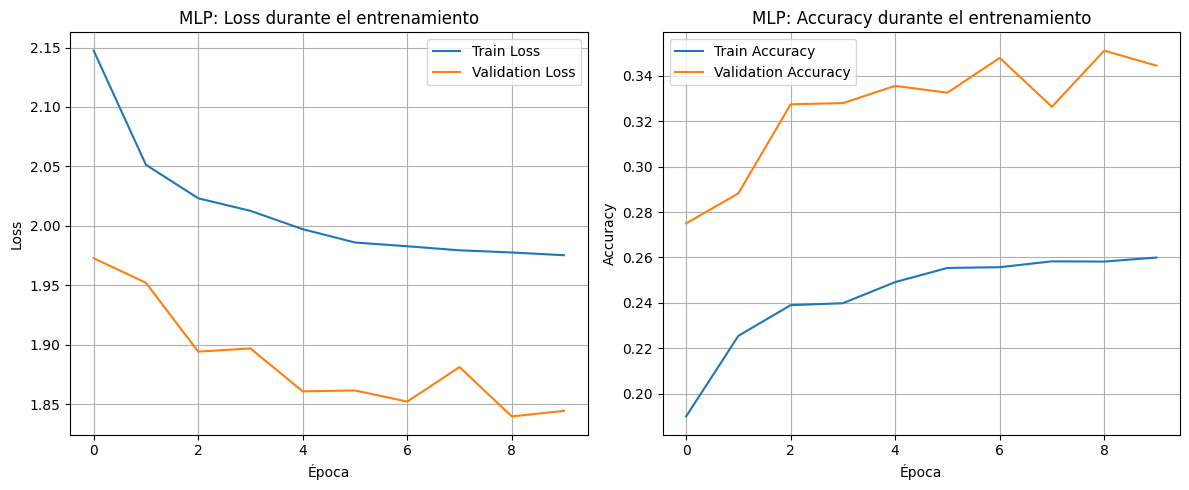

Curvas de aprendizaje MLP guardadas en: figuras/2025-11-15_090510_N_A_local_Colab_mlp_curvas.png


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import pandas as pd
import json
import datetime
import os
import yaml # Para actualizar params.yaml

# --- 1. Define MLP ---
def create_mlp_model(input_shape=(32, 32, 3), num_classes=10, dropout_rate=0.5):
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape, name="flatten_input"),
        layers.Dense(256, activation='relu', name="dense_256"),
        layers.Dropout(dropout_rate, name="dropout_50"),
        layers.Dense(num_classes, activation='softmax', name="output_softmax")
    ])
    return model

mlp_model = create_mlp_model(dropout_rate=0.5)
mlp_model.summary()

# --- 2. Compila ---
# Usamos el LR inicial de 1e-3 definido en params.yaml
initial_lr = 1e-3 # Puedes leerlo de params.yaml si quieres ser más estricto
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
mlp_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

print(f"\nModelo MLP compilado con Adam(lr={initial_lr}) y loss='categorical_crossentropy'.")


# --- 3. Entrena 10 épocas, batch=64, con validación ---
BATCH_SIZE = 64
EPOCHS_MLP = 10 # 10 épocas para el baseline MLP

print(f"\nEntrenando modelo MLP por {EPOCHS_MLP} épocas con batch_size={BATCH_SIZE}...")
mlp_history = mlp_model.fit(x_train, y_train_one_hot,
                            epochs=EPOCHS_MLP,
                            batch_size=BATCH_SIZE,
                            validation_data=(x_valid, y_valid_one_hot),
                            verbose=1)

# --- 4. Evalúa en validación y test ---
print("\nEvaluando modelo MLP en conjunto de validación...")
val_loss_mlp, val_acc_mlp = mlp_model.evaluate(x_valid, y_valid_one_hot, verbose=0)
print(f"MLP - Val Loss: {val_loss_mlp:.4f}, Val Accuracy: {val_acc_mlp:.4f}")

print("\nEvaluando modelo MLP en conjunto de test...")
test_loss_mlp, test_acc_mlp = mlp_model.evaluate(x_test, y_test_one_hot, verbose=0)
print(f"MLP - Test Loss: {test_loss_mlp:.4f}, Test Accuracy: {test_acc_mlp:.4f}")

# --- R3: Actualiza results/params.yaml con hiperparámetros reales del MLP ---
# Para esto, primero necesitamos el commit_id actual.
# En Colab, si tienes tu repo montado, puedes ejecutar comandos git.
# Si no, deberás añadir manualmente el commit ID cuando hagas commit.
# Por ahora, usaremos un placeholder o lo obtenemos si el repo está clonado.
# (Suponiendo que ya has clonado y estás trabajando dentro del repo si quieres git real)
try:
    # Si tienes el repo clonado y estás en el dir correcto
    import subprocess
    commit_id_mlp = subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).strip().decode('ascii')
except (FileNotFoundError, subprocess.CalledProcessError):
    commit_id_mlp = "N/A_local_Colab" # Placeholder si no hay git o no está el repo
print(f"Commit ID actual: {commit_id_mlp}")

# Cargar params.yaml
with open('results/params.yaml', 'r') as f:
    params = yaml.safe_load(f)

params['model_configs']['mlp_baseline'] = {
    'architecture': 'Flatten -> Dense(256,relu) -> Dropout(0.5) -> Dense(10,softmax)',
    'input_shape': list(x_train.shape[1:]),
    'num_parameters': mlp_model.count_params(),
    'optimizer': 'Adam',
    'learning_rate': initial_lr,
    'loss_function': 'categorical_crossentropy',
    'metrics': ['accuracy'],
    'epochs': EPOCHS_MLP,
    'batch_size': BATCH_SIZE,
    'dropout_rate': 0.5
}
params['training_configs']['epochs'] = EPOCHS_MLP # Actualiza el valor general si este es el primer entrenamiento
params['training_configs']['batch_size'] = BATCH_SIZE

with open('results/params.yaml', 'w') as f:
    yaml.dump(params, f, sort_keys=False)
print("\nresults/params.yaml actualizado con configuración MLP.")


# --- Exporta history a results/history.csv ---
history_df_mlp = pd.DataFrame(mlp_history.history)
os.makedirs('results', exist_ok=True) # Asegura que la carpeta existe
# Sanitize commit_id_mlp for filename to avoid directory creation issues
sanitized_commit_id_mlp = commit_id_mlp.replace('/', '_').replace('\\', '_')
history_filename_mlp = f"results/{datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')}_{sanitized_commit_id_mlp}_mlp_history.csv"
history_df_mlp.to_csv(history_filename_mlp, index=False)
print(f"Historial de entrenamiento MLP guardado en: {history_filename_mlp}")


# --- Exporta métricas a results/metrics.json ---
metrics_mlp = {
    'model_name': 'mlp_baseline',
    'val_acc': val_acc_mlp,
    'test_acc': test_acc_mlp,
    'val_loss': val_loss_mlp,
    'test_loss': test_loss_mlp,
    'num_parameters': mlp_model.count_params(),
    'epochs_trained': EPOCHS_MLP,
    'commit_id': commit_id_mlp,
    'timestamp': datetime.datetime.now().isoformat(),
    'history_file': history_filename_mlp
}

# Puedes cargar un metrics.json existente y añadir/actualizar
metrics_path = 'results/metrics.json'
all_metrics = []
if os.path.exists(metrics_path):
    with open(metrics_path, 'r') as f:
        try:
            all_metrics = json.load(f)
            if not isinstance(all_metrics, list): # Asegurar que es una lista para append
                all_metrics = [all_metrics]
        except json.JSONDecodeError:
            all_metrics = [] # Si el JSON está vacío o mal formado, inicializar
else:
    all_metrics = []

all_metrics.append(metrics_mlp)

with open(metrics_path, 'w') as f:
    json.dump(all_metrics, f, indent=4)
print(f"Métricas MLP guardadas/actualizadas en: {metrics_path}")


# --- Nombra figuras con fecha+commit y súbelas a figuras/ ---
os.makedirs('figuras', exist_ok=True)
fig_filename_mlp = f"figuras/{datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')}_{sanitized_commit_id_mlp}_mlp_curvas.png"

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(mlp_history.history['loss'], label='Train Loss')
plt.plot(mlp_history.history['val_loss'], label='Validation Loss')
plt.title('MLP: Loss durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(mlp_history.history['accuracy'], label='Train Accuracy')
plt.plot(mlp_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MLP: Accuracy durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(fig_filename_mlp)
plt.show()
print(f"Curvas de aprendizaje MLP guardadas en: {fig_filename_mlp}")

¿Hay overfitting? Observa las curvas de loss y accuracy. Si la val_loss comienza a subir mientras la train_loss sigue bajando (o si la val_accuracy se estanca/baja mientras la train_accuracy sigue subiendo), entonces hay sobreajuste. Es muy probable que un MLP simple sobreajuste rápidamente en CIFAR-10 debido a la alta dimensionalidad de la entrada aplanada y la falta de sesgo espacial.

¿Por qué el aplanado limita la generalización? Al "aplanar" la imagen (convertir la matriz 32x32x3 en un vector 3072), el modelo pierde toda la información espacial (qué píxeles están cerca de cuáles, la estructura 2D de la imagen). Para el MLP, un píxel en (0,0) es tan "cercano" en la entrada como un píxel en (31,31) si están en posiciones de índice secuenciales en el vector aplanado. Esto significa que el MLP debe aprender patrones para cada posible ubicación y orientación de los objetos en la imagen de forma independiente, lo que requiere muchísimos más datos y es ineficiente para la visión por computadora. Los patrones locales que son clave para reconocer objetos (bordes, texturas) no son inherentemente capturados por una red densa sobre una entrada aplanada, lo que limita severamente su capacidad para generalizar a nuevas imágenes.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
import pandas as pd
import json
import datetime
import os
import yaml # Para actualizar params.yaml
import subprocess # Para obtener commit ID

# --- 1. Define CNN ---
def create_simple_cnn_model(input_shape=(32, 32, 3), num_classes=10, dropout_rate=0.5):
    model = models.Sequential([
        # Primer bloque Conv -> ReLU -> Pool
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, name="conv2d_32"),
        layers.MaxPooling2D((2, 2), name="maxpool2d_1"),

        # Segundo bloque Conv -> ReLU -> Pool
        layers.Conv2D(64, (3, 3), activation='relu', name="conv2d_64"),
        layers.MaxPooling2D((2, 2), name="maxpool2d_2"),

        # Flatten y capas densas
        layers.Flatten(name="flatten_output"),
        layers.Dense(128, activation='relu', name="dense_128"),
        layers.Dropout(dropout_rate, name="dropout_50_cnn"), # Mismo dropout rate para consistencia
        layers.Dense(num_classes, activation='softmax', name="output_softmax_cnn")
    ])
    return model

cnn_model = create_simple_cnn_model(dropout_rate=0.5)
cnn_model.summary()

# --- 2. Compila ---
initial_lr = 1e-3 # Mantén el mismo LR para una comparación justa inicial
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
cnn_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

print(f"\nModelo CNN simple compilado con Adam(lr={initial_lr}) y loss='categorical_crossentropy'.")

# --- 3. Entrena 15 épocas, batch=64, con validación ---
BATCH_SIZE = 64
EPOCHS_CNN_SIMPLE = 15 # 15 épocas para la CNN simple

print(f"\nEntrenando modelo CNN simple por {EPOCHS_CNN_SIMPLE} épocas con batch_size={BATCH_SIZE}...")
cnn_simple_history = cnn_model.fit(x_train, y_train_one_hot,
                                   epochs=EPOCHS_CNN_SIMPLE,
                                   batch_size=BATCH_SIZE,
                                   validation_data=(x_valid, y_valid_one_hot),
                                   verbose=1)

# --- 4. Evalúa en validación y test ---
print("\nEvaluando modelo CNN simple en conjunto de validación...")
val_loss_cnn_simple, val_acc_cnn_simple = cnn_model.evaluate(x_valid, y_valid_one_hot, verbose=0)
print(f"CNN Simple - Val Loss: {val_loss_cnn_simple:.4f}, Val Accuracy: {val_acc_cnn_simple:.4f}")

print("\nEvaluando modelo CNN simple en conjunto de test...")
test_loss_cnn_simple, test_acc_cnn_simple = cnn_model.evaluate(x_test, y_test_one_hot, verbose=0)
print(f"CNN Simple - Test Loss: {test_loss_cnn_simple:.4f}, Test Accuracy: {test_acc_cnn_simple:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_output (Flatten)        │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50_cnn (Dropout)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax_cnn (Dense)      │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,722 (1.20 MB)

 Trainable params: 315,722 (1.20 MB)

 Non-trainable params: 0 (0.00 B)


Modelo CNN simple compilado con Adam(lr=0.001) y loss='categorical_crossentropy'.

Entrenando modelo CNN simple por 15 épocas con batch_size=64...
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 84ms/step - accuracy: 0.3005 - loss: 1.8817 - val_accuracy: 0.5222 - val_loss: 1.3380
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.4841 - loss: 1.4266 - val_accuracy: 0.5828 - val_loss: 1.1740
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 79ms/step - accuracy: 0.5516 - loss: 1.2697 - val_accuracy: 0.6189 - val_loss: 1.0771
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 79ms/step - accuracy: 0.5864 - loss: 1.1696 - val_accuracy: 0.6386 - val_loss: 1.0342
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.6193 - loss: 1.0871 - val_accuracy: 0.6567 - val_loss: 0.9813
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - accuracy: 0.6376 - loss: 1.0409 - val_accuracy: 0.6588 - val_loss: 0.9783
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.6498

Commit ID actual: N/A_local_Colab

results/params.yaml actualizado con configuración CNN simple.
Historial de entrenamiento CNN simple guardado en: results/2025-11-15_092313_N_A_local_Colab_cnn_simple_history.csv
Métricas CNN simple guardadas/actualizadas en: results/metrics.json


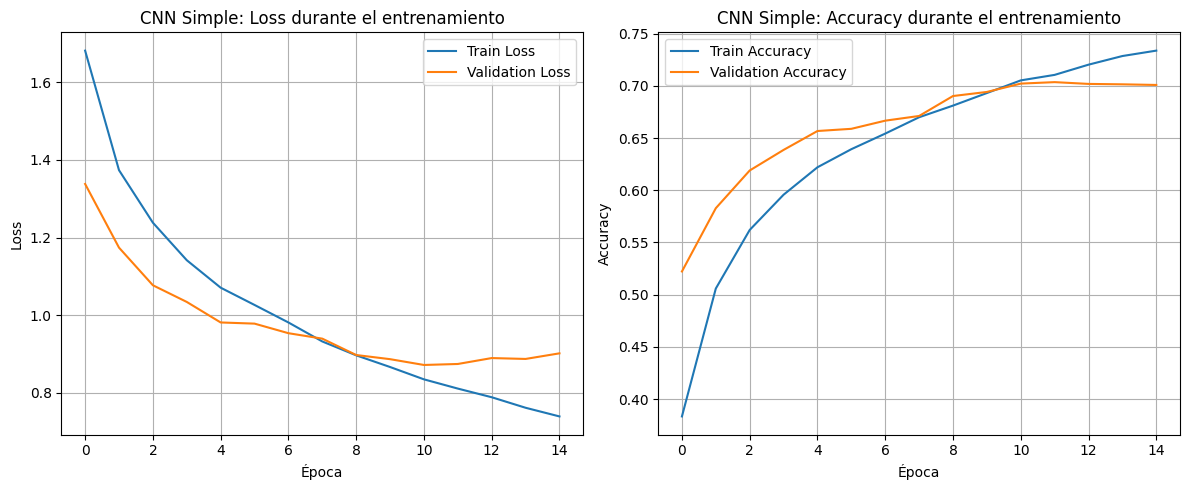

Curvas de aprendizaje CNN simple guardadas en: figuras/2025-11-15_092313_N_A_local_Colab_cnn_simple_curvas.png


In [ ]:
# --- Obtener commit ID ---
try:
    import subprocess
    commit_id_cnn_simple = subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).strip().decode('ascii')
except (FileNotFoundError, subprocess.CalledProcessError):
    commit_id_cnn_simple = "N/A_local_Colab"
print(f"Commit ID actual: {commit_id_cnn_simple}")

# --- R3: Actualiza results/params.yaml ---
with open('results/params.yaml', 'r') as f:
    params = yaml.safe_load(f)

params['model_configs']['cnn_simple_2_blocks'] = {
    'architecture': '[Conv(32)→ReLU→Pool]x1 → [Conv(64)→ReLU→Pool]x1 → Flatten → Dense(128) → Dropout(0.5) → Dense(10,softmax)',
    'input_shape': list(x_train.shape[1:]),
    'num_parameters': cnn_model.count_params(),
    'optimizer': 'Adam',
    'learning_rate': initial_lr,
    'loss_function': 'categorical_crossentropy',
    'metrics': ['accuracy'],
    'epochs': EPOCHS_CNN_SIMPLE,
    'batch_size': BATCH_SIZE,
    'dropout_rate': 0.5,
    'l2_reg': 0.0 # Especificar si no se usa
}

with open('results/params.yaml', 'w') as f:
    yaml.dump(params, f, sort_keys=False)
print("\nresults/params.yaml actualizado con configuración CNN simple.")

# --- Exporta history y metrics ---
history_df_cnn_simple = pd.DataFrame(cnn_simple_history.history)
# Sanitize commit_id_cnn_simple for filename to avoid directory creation issues
sanitized_commit_id_cnn_simple = commit_id_cnn_simple.replace('/', '_').replace('\\', '_')
history_filename_cnn_simple = f"results/{datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')}_{sanitized_commit_id_cnn_simple}_cnn_simple_history.csv"
history_df_cnn_simple.to_csv(history_filename_cnn_simple, index=False)
print(f"Historial de entrenamiento CNN simple guardado en: {history_filename_cnn_simple}")

metrics_cnn_simple = {
    'model_name': 'cnn_simple_2_blocks',
    'val_acc': val_acc_cnn_simple,
    'test_acc': test_acc_cnn_simple,
    'val_loss': val_loss_cnn_simple,
    'test_loss': test_loss_cnn_simple,
    'num_parameters': cnn_model.count_params(),
    'epochs_trained': EPOCHS_CNN_SIMPLE,
    'commit_id': commit_id_cnn_simple,
    'timestamp': datetime.datetime.now().isoformat(),
    'history_file': history_filename_cnn_simple
}

metrics_path = 'results/metrics.json'
all_metrics = []
if os.path.exists(metrics_path):
    with open(metrics_path, 'r') as f:
        try:
            all_metrics = json.load(f)
            if not isinstance(all_metrics, list):
                all_metrics = [all_metrics]
        except json.JSONDecodeError:
            all_metrics = []
else:
    all_metrics = []
all_metrics.append(metrics_cnn_simple)

with open(metrics_path, 'w') as f:
    json.dump(all_metrics, f, indent=4)
print(f"Métricas CNN simple guardadas/actualizadas en: {metrics_path}")

# --- Guarda figuras ---
os.makedirs('figuras', exist_ok=True)
fig_filename_cnn_simple = f"figuras/{datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')}_{sanitized_commit_id_cnn_simple}_cnn_simple_curvas.png"

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_simple_history.history['loss'], label='Train Loss')
plt.plot(cnn_simple_history.history['val_loss'], label='Validation Loss')
plt.title('CNN Simple: Loss durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cnn_simple_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_simple_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Simple: Accuracy durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(fig_filename_cnn_simple)
plt.show()
print(f"Curvas de aprendizaje CNN simple guardadas en: {fig_filename_cnn_simple}")

In [ ]:
# --- Carga las métricas guardadas y crea la tabla comparativa ---
metrics_path = 'results/metrics.json'
if os.path.exists(metrics_path):
    with open(metrics_path, 'r') as f:
        all_metrics = json.load(f)
else:
    all_metrics = []

# Filtrar para obtener las métricas del MLP y la CNN simple
mlp_metrics = next((m for m in all_metrics if m['model_name'] == 'mlp_baseline'), None)
cnn_metrics = next((m for m in all_metrics if m['model_name'] == 'cnn_simple_2_blocks'), None)

if mlp_metrics and cnn_metrics:
    comparison_data = {
        'Modelo': ['MLP Baseline', 'CNN Simple (2 bloques)'],
        'Parámetros': [mlp_metrics['num_parameters'], cnn_metrics['num_parameters']],
        'Tiempo/Época (aprox.)': ['- (estimar manualmente)', '- (estimar manualmente)'], # Tendrás que rellenar esto al ejecutar
        'Val Accuracy': [mlp_metrics['val_acc'], cnn_metrics['val_acc']],
        'Test Accuracy': [mlp_metrics['test_acc'], cnn_metrics['test_acc']]
    }
    comparison_df = pd.DataFrame(comparison_data)
    print("\n--- Tabla Comparativa MLP vs CNN Simple ---")
    print(comparison_df.to_string(index=False))

    # Guardar la tabla en results/
    comparison_table_filename = f"results/{datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')}_model_comparison.csv"
    comparison_df.to_csv(comparison_table_filename, index=False)
    print(f"\nTabla comparativa guardada en: {comparison_table_filename}")
else:
    print("\nNo se pudieron encontrar las métricas de MLP o CNN simple para la comparación.")

# NOTA: Para el 'Tiempo/Época', debes observar el output de la celda de entrenamiento
# en Colab y anotar el tiempo promedio por época (e.g., "10s/epoch").
# Luego puedes editar el CSV o el dataframe aquí para incluir esos valores.


--- Tabla Comparativa MLP vs CNN Simple ---
                Modelo  Parámetros   Tiempo/Época (aprox.)  Val Accuracy  Test Accuracy
          MLP Baseline      789258 - (estimar manualmente)        0.3444         0.3413
CNN Simple (2 bloques)      315722 - (estimar manualmente)        0.7008         0.6950

Tabla comparativa guardada en: results/2025-11-15_092411_model_comparison.csv


¿Por qué la CNN puede rendir mejor con igual/menos parámetros?
La CNN rinde mejor porque aprovecha el "sesgo inductivo" de la localidad y la invarianza traslacional, inherentes a los datos de imagen. Los filtros convolucionales aprenden patrones locales y los reutilizan en toda la imagen (compartiendo pesos). Las capas de pooling luego resumen estos patrones, haciendo el modelo robusto a pequeñas variaciones en la posición del objeto. En contraste, el MLP con una entrada aplanada trata cada píxel independientemente, perdiendo la estructura espacial. Aunque el MLP podría tener más parámetros, muchos de ellos se usan para "memorizar" ubicaciones específicas, mientras que los parámetros de la CNN son más eficientes al capturar características generalizables. Esto permite a la CNN obtener mayor precisión con menos parámetros totales y una mejor capacidad de generalización.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import json
import datetime
import os
import yaml
import subprocess

# --- 1. Añade L2=1e-4 en todas las Conv y en Dense(128) ---
L2_REG_FACTOR = 1e-4

def create_cnn_l2_model(input_shape=(32, 32, 3), num_classes=10, dropout_rate=0.5, l2_factor=L2_REG_FACTOR):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape,
                      kernel_regularizer=regularizers.l2(l2_factor), name="conv2d_32_l2"),
        layers.MaxPooling2D((2, 2), name="maxpool2d_1_l2"),

        layers.Conv2D(64, (3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(l2_factor), name="conv2d_64_l2"),
        layers.MaxPooling2D((2, 2), name="maxpool2d_2_l2"),

        layers.Flatten(name="flatten_output_l2"),
        layers.Dense(128, activation='relu',
                      kernel_regularizer=regularizers.l2(l2_factor), name="dense_128_l2"),
        layers.Dropout(dropout_rate, name="dropout_50_cnn_l2"),
        layers.Dense(num_classes, activation='softmax', name="output_softmax_cnn_l2")
    ])
    return model

cnn_l2_model = create_cnn_l2_model(dropout_rate=0.5, l2_factor=L2_REG_FACTOR)
cnn_l2_model.summary()

# --- Compila (igual que antes) ---
initial_lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
cnn_l2_model.compile(optimizer=optimizer,
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

print(f"\nModelo CNN con L2 compilado con Adam(lr={initial_lr}) y loss='categorical_crossentropy'.")

# --- Configura EarlyStopping ---
# monitor val_loss, patience=5, restore_best_weights=True
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# --- Entrena hasta 30 épocas (deja que la parada decida) ---
BATCH_SIZE = 64
EPOCHS_MAX_L2 = 30 # Máximo de épocas, EarlyStopping parará antes si no hay mejora

print(f"\nEntrenando modelo CNN con L2 y EarlyStopping por hasta {EPOCHS_MAX_L2} épocas con batch_size={BATCH_SIZE}...")
cnn_l2_history = cnn_l2_model.fit(x_train, y_train_one_hot,
                                  epochs=EPOCHS_MAX_L2,
                                  batch_size=BATCH_SIZE,
                                  validation_data=(x_valid, y_valid_one_hot),
                                  callbacks=[early_stopping_callback],
                                  verbose=1)

# --- Evalúa en validación y test ---
print("\nEvaluando modelo CNN con L2 y EarlyStopping en conjunto de validación...")
val_loss_cnn_l2, val_acc_cnn_l2 = cnn_l2_model.evaluate(x_valid, y_valid_one_hot, verbose=0)
print(f"CNN + L2 + ES - Val Loss: {val_loss_cnn_l2:.4f}, Val Accuracy: {val_acc_cnn_l2:.4f}")

print("\nEvaluando modelo CNN con L2 y EarlyStopping en conjunto de test...")
test_loss_cnn_l2, test_acc_cnn_l2 = cnn_l2_model.evaluate(x_test, y_test_one_hot, verbose=0)
print(f"CNN + L2 + ES - Test Loss: {test_loss_cnn_l2:.4f}, Test Accuracy: {test_acc_cnn_l2:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32_l2 (Conv2D)           │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1_l2 (MaxPooling2D)   │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64_l2 (Conv2D)           │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2_l2 (MaxPooling2D)   │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_output_l2 (Flatten)     │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128_l2 (Dense)            │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50_cnn_l2 (Dropout)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax_cnn_l2 (Dense)   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,722 (1.20 MB)

 Trainable params: 315,722 (1.20 MB)

 Non-trainable params: 0 (0.00 B)


Modelo CNN con L2 compilado con Adam(lr=0.001) y loss='categorical_crossentropy'.

Entrenando modelo CNN con L2 y EarlyStopping por hasta 30 épocas con batch_size=64...
Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 86ms/step - accuracy: 0.3028 - loss: 1.9093 - val_accuracy: 0.5163 - val_loss: 1.3632
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.4920 - loss: 1.4534 - val_accuracy: 0.5839 - val_loss: 1.2138
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.5528 - loss: 1.3093 - val_accuracy: 0.6181 - val_loss: 1.1170
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 79ms/step - accuracy: 0.5933 - loss: 1.2257 - val_accuracy: 0.6449 - val_loss: 1.0694
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 82ms/step - accuracy: 0.6160 - loss: 1.1569 - val_accuracy: 0.6468 - val_loss: 1.0639
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 79ms/step - accuracy: 0.6353 - loss: 1.1118 - val_accuracy: 0.6714 - val_loss: 1.0232
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 76ms/s

Commit ID actual: N/A_local_Colab

results/params.yaml actualizado con configuración CNN + L2 + EarlyStopping.
Historial de entrenamiento CNN + L2 + ES guardado en: results/2025-11-15_094747_N_A_local_Colab_cnn_l2_es_history.csv
Métricas CNN + L2 + ES guardadas/actualizadas en: results/metrics.json


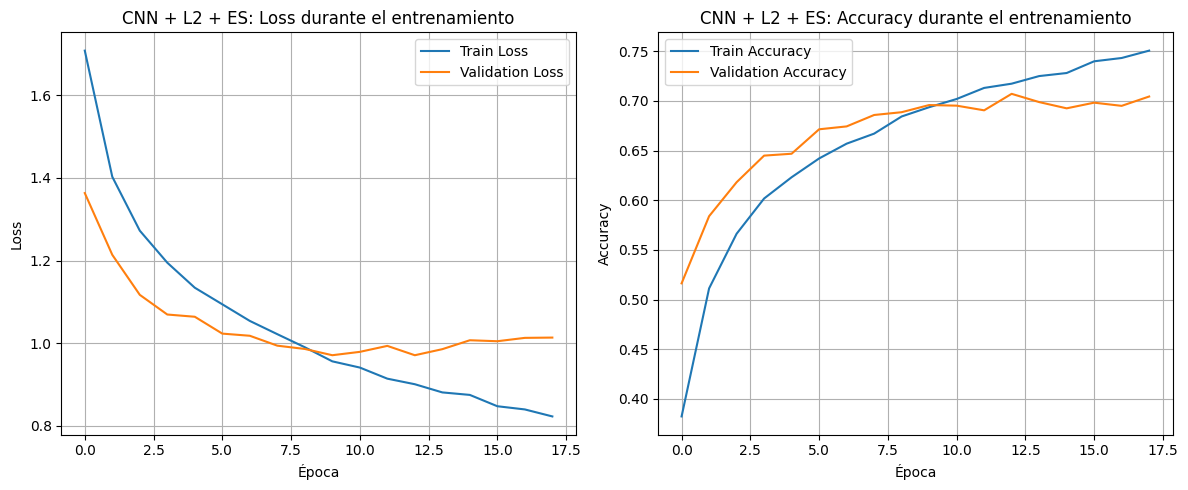

Curvas de aprendizaje CNN + L2 + ES guardadas en: figuras/2025-11-15_094747_N_A_local_Colab_cnn_l2_es_curvas.png


In [ ]:
# --- Obtener commit ID ---
try:
    commit_id_cnn_l2 = subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).strip().decode('ascii')
except (FileNotFoundError, subprocess.CalledProcessError):
    commit_id_cnn_l2 = "N/A_local_Colab"
print(f"Commit ID actual: {commit_id_cnn_l2}")

# --- R3: Actualiza results/params.yaml ---
with open('results/params.yaml', 'r') as f:
    params = yaml.safe_load(f)

params['model_configs']['cnn_2_blocks_l2_es'] = {
    'architecture': '[Conv(32,l2)→ReLU→Pool]x1 → [Conv(64,l2)→ReLU→Pool]x1 → Flatten → Dense(128,l2) → Dropout(0.5) → Dense(10,softmax)',
    'input_shape': list(x_train.shape[1:]),
    'num_parameters': cnn_l2_model.count_params(),
    'optimizer': 'Adam',
    'learning_rate': initial_lr,
    'loss_function': 'categorical_crossentropy',
    'metrics': ['accuracy'],
    'epochs_max': EPOCHS_MAX_L2, # Épocas máximas si ES no detiene
    'epochs_trained': len(cnn_l2_history.epoch), # Épocas reales entrenadas
    'batch_size': BATCH_SIZE,
    'dropout_rate': 0.5,
    'l2_reg': L2_REG_FACTOR,
    'early_stopping': {'monitor': 'val_loss', 'patience': early_stopping_callback.patience, 'restore_best_weights': early_stopping_callback.restore_best_weights}
}
params['training_configs']['l2_reg'] = L2_REG_FACTOR # Actualizar valor general
params['training_configs']['early_stopping'] = params['model_configs']['cnn_2_blocks_l2_es']['early_stopping']

with open('results/params.yaml', 'w') as f:
    yaml.dump(params, f, sort_keys=False)
print("\nresults/params.yaml actualizado con configuración CNN + L2 + EarlyStopping.")

# --- Exporta history y metrics ---
history_df_cnn_l2 = pd.DataFrame(cnn_l2_history.history)
# Sanitize commit_id_cnn_l2 for filename to avoid directory creation issues
sanitized_commit_id_cnn_l2 = commit_id_cnn_l2.replace('/', '_').replace('\\', '_')
history_filename_cnn_l2 = f"results/{datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')}_{sanitized_commit_id_cnn_l2}_cnn_l2_es_history.csv"
history_df_cnn_l2.to_csv(history_filename_cnn_l2, index=False)
print(f"Historial de entrenamiento CNN + L2 + ES guardado en: {history_filename_cnn_l2}")

metrics_cnn_l2 = {
    'model_name': 'cnn_2_blocks_l2_es',
    'val_acc': val_acc_cnn_l2,
    'test_acc': test_acc_cnn_l2,
    'val_loss': val_loss_cnn_l2,
    'test_loss': test_loss_cnn_l2,
    'num_parameters': cnn_l2_model.count_params(),
    'epochs_max': EPOCHS_MAX_L2,
    'epochs_trained': len(cnn_l2_history.epoch),
    'commit_id': commit_id_cnn_l2,
    'timestamp': datetime.datetime.now().isoformat(),
    'history_file': history_filename_cnn_l2,
    'l2_reg_factor': L2_REG_FACTOR,
    'early_stopping_patience': early_stopping_callback.patience
}

metrics_path = 'results/metrics.json'
all_metrics = []
if os.path.exists(metrics_path):
    with open(metrics_path, 'r') as f:
        try:
            all_metrics = json.load(f)
            if not isinstance(all_metrics, list):
                all_metrics = [all_metrics]
        except json.JSONDecodeError:
            all_metrics = []
else:
    all_metrics = []
all_metrics.append(metrics_cnn_l2)

with open(metrics_path, 'w') as f:
    json.dump(all_metrics, f, indent=4)
print(f"Métricas CNN + L2 + ES guardadas/actualizadas en: {metrics_path}")

# --- Guarda figuras ---
os.makedirs('figuras', exist_ok=True)
fig_filename_cnn_l2 = f"figuras/{datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')}_{sanitized_commit_id_cnn_l2}_cnn_l2_es_curvas.png"

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_l2_history.history['loss'], label='Train Loss')
plt.plot(cnn_l2_history.history['val_loss'], label='Validation Loss')
plt.title('CNN + L2 + ES: Loss durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cnn_l2_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_l2_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN + L2 + ES: Accuracy durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(fig_filename_cnn_l2)
plt.show()
print(f"Curvas de aprendizaje CNN + L2 + ES guardadas en: {fig_filename_cnn_l2}")

¿Se redujo la brecha train/val? Compara las curvas de loss y accuracy de este entrenamiento con las del cnn_simple_history anterior. La L2 y el Early Stopping deberían haber ayudado a cerrar la brecha entre el rendimiento de entrenamiento y validación, indicando menos sobreajuste. La val_loss podría ser más estable o dejar de subir, y la val_accuracy podría mantenerse más cerca de la train_accuracy o alcanzar un pico más alto y sostenible.

¿Subió test acc? Compara test_acc_cnn_l2 con test_acc_cnn_simple. Idealmente, la regularización debería llevar a una mejora en la precisión en el conjunto de test, ya que el modelo generaliza mejor. Si no hay una mejora drástica, podría ser que la regularización L2 fue demasiado fuerte/débil o que el modelo todavía tiene espacio para mejorar con otras técnicas.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import pandas as pd
import json
import datetime
import os
import yaml
import subprocess
import numpy as np # Para visualización de aumentos

# --- Configuración de regularización y callbacks ---
L2_REG_FACTOR = 1e-4
DROPOUT_RATE = 0.5
EARLY_STOPPING_PATIENCE = 5
LR_PLATEAU_FACTOR = 0.2
LR_PLATEAU_PATIENCE = 3

# --- 1. Diseña augment moderado e inserta tras Input ---
# Utilizaremos las capas de preprocesamiento de Keras para Data Augmentation
data_augmentation_layers = tf.keras.Sequential([
    layers.RandomFlip("horizontal", seed=SEED, name="random_flip"),
    layers.RandomRotation(factor=0.1, seed=SEED, name="random_rotation"), # Rotaciones leves (±10% * 2pi)
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=SEED, name="random_zoom"), # Zoom in/out leve
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1, seed=SEED, name="random_translation"), # Traslación leve
    # layers.RandomBrightness(factor=0.1, seed=SEED, name="random_brightness"), # Brillo leve, opcional y experimental
], name="data_augmentation_pipeline")


def create_cnn_augmented_model(input_shape=(32, 32, 3), num_classes=10, dropout_rate=DROPOUT_RATE, l2_factor=L2_REG_FACTOR, augment_layers=None):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    # Si se proporcionan capas de aumento, las insertamos aquí
    if augment_layers:
        x = augment_layers(x)

    # Bloques Conv -> ReLU -> Pool con L2
    x = layers.Conv2D(32, (3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(l2_factor), name="conv2d_32_aug_l2")(x)
    x = layers.MaxPooling2D((2, 2), name="maxpool2d_1_aug_l2")(x)

    x = layers.Conv2D(64, (3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(l2_factor), name="conv2d_64_aug_l2")(x)
    x = layers.MaxPooling2D((2, 2), name="maxpool2d_2_aug_l2")(x)

    # Flatten y capas densas con L2 y Dropout
    x = layers.Flatten(name="flatten_output_aug_l2")(x)
    x = layers.Dense(128, activation='relu',
                      kernel_regularizer=regularizers.l2(l2_factor), name="dense_128_aug_l2")(x)
    x = layers.Dropout(dropout_rate, name="dropout_50_cnn_aug_l2")(x)
    outputs = layers.Dense(num_classes, activation='softmax', name="output_softmax_cnn_aug_l2")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

cnn_augmented_model = create_cnn_augmented_model(
    dropout_rate=DROPOUT_RATE,
    l2_factor=L2_REG_FACTOR,
    augment_layers=data_augmentation_layers # Pasamos las capas de aumento
)
cnn_augmented_model.summary()

# --- 2. Compila ---
initial_lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
cnn_augmented_model.compile(optimizer=optimizer,
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

print(f"\nModelo CNN con Augment+L2 compilado con Adam(lr={initial_lr}) y loss='categorical_crossentropy'.")

# --- 3. Añade ReduceLROnPlateau junto a EarlyStopping ---
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=EARLY_STOPPING_PATIENCE,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_on_plateau_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_PLATEAU_FACTOR, # Reduce LR a 20%
    patience=LR_PLATEAU_PATIENCE, # Espera 3 épocas sin mejora
    min_lr=1e-7, # LR mínimo
    verbose=1
)

callbacks_list = [early_stopping_callback, reduce_lr_on_plateau_callback]

# --- 4. Entrena 20 épocas ---
BATCH_SIZE = 64
EPOCHS_MAX_AUG = 20 # Máximo de épocas, callbacks detendrán antes si no hay mejora

print(f"\nEntrenando modelo CNN con Augment, L2 y EarlyStopping+ReduceLR por hasta {EPOCHS_MAX_AUG} épocas con batch_size={BATCH_SIZE}...")
cnn_augmented_history = cnn_augmented_model.fit(x_train, y_train_one_hot,
                                                epochs=EPOCHS_MAX_AUG,
                                                batch_size=BATCH_SIZE,
                                                validation_data=(x_valid, y_valid_one_hot),
                                                callbacks=callbacks_list,
                                                verbose=1)

# --- Evalúa en validación y test ---
print("\nEvaluando modelo CNN con Augment, L2 y EarlyStopping+ReduceLR en conjunto de validación...")
val_loss_cnn_aug, val_acc_cnn_aug = cnn_augmented_model.evaluate(x_valid, y_valid_one_hot, verbose=0)
print(f"CNN + Augment + L2 + ES + ReduceLR - Val Loss: {val_loss_cnn_aug:.4f}, Val Accuracy: {val_acc_cnn_aug:.4f}")

print("\nEvaluando modelo CNN con Augment, L2 y EarlyStopping+ReduceLR en conjunto de test...")
test_loss_cnn_aug, test_acc_cnn_aug = cnn_augmented_model.evaluate(x_test, y_test_one_hot, verbose=0)
print(f"CNN + Augment + L2 + ES + ReduceLR - Test Loss: {test_loss_cnn_aug:.4f}, Test Accuracy: {test_acc_cnn_aug:.4f}")

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation_pipeline      │ (None, 32, 32, 3)      │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32_aug_l2 (Conv2D)       │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1_aug_l2              │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64_aug_l2 (Conv2D)       │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2_aug_l2              │ (None, 6, 6, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_output_aug_l2 (Flatten) │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128_aug_l2 (Dense)        │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50_cnn_aug_l2 (Dropout) │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax_cnn_aug_l2       │ (None, 10)             │         1,290 │
│ (Dense)                         │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,722 (1.20 MB)

 Trainable params: 315,722 (1.20 MB)

 Non-trainable params: 0 (0.00 B)


Modelo CNN con Augment+L2 compilado con Adam(lr=0.001) y loss='categorical_crossentropy'.

Entrenando modelo CNN con Augment, L2 y EarlyStopping+ReduceLR por hasta 20 épocas con batch_size=64...
Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 64s 97ms/step - accuracy: 0.2400 - loss: 2.0529 - val_accuracy: 0.4473 - val_loss: 1.5274 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 95ms/step - accuracy: 0.3810 - loss: 1.7155 - val_accuracy: 0.4633 - val_loss: 1.4788 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 99ms/step - accuracy: 0.4111 - loss: 1.6494 - val_accuracy: 0.4898 - val_loss: 1.4197 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - accuracy: 0.4357 - loss: 1.5912 - val_accuracy: 0.5067 - val_loss: 1.4158 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 93ms/step - accuracy: 0.4556 - loss: 1.5439 - val_accuracy: 0.5201 - val_loss: 1.4002 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━

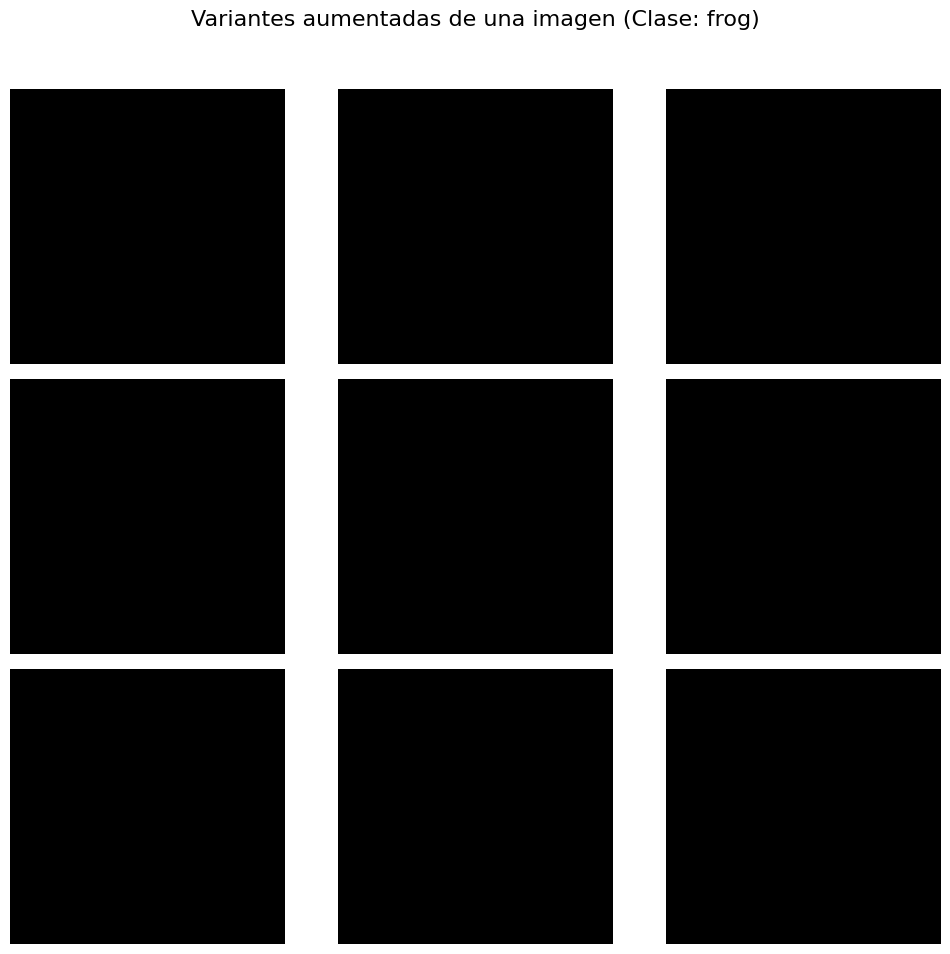

In [ ]:
# --- Visualiza 9 variantes de una imagen como control ---
# Tomamos una imagen del conjunto de entrenamiento
sample_image = x_train[0]
plt.figure(figsize=(10, 10))
plt.suptitle(f"Variantes aumentadas de una imagen (Clase: {class_names[y_train[0]]})", fontsize=16)

for i in range(9):
    augmented_image = data_augmentation_layers(tf.expand_dims(sample_image, 0)) # Añade dimensión de batch
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8")) # Convierte a numpy y uint8 para imshow
    plt.axis("off")
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta para el suptitle
plt.show()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation_pipeline      │ (None, 32, 32, 3)      │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32_aug_l2 (Conv2D)       │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1_aug_l2              │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64_aug_l2 (Conv2D)       │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2_aug_l2              │ (None, 6, 6, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_output_aug_l2 (Flatten) │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128_aug_l2 (Dense)        │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50_cnn_aug_l2 (Dropout) │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax_cnn_aug_l2       │ (None, 10)             │         1,290 │
│ (Dense)                         │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,722 (1.20 MB)

 Trainable params: 315,722 (1.20 MB)

 Non-trainable params: 0 (0.00 B)


Modelo CNN con Augment+L2 compilado con Adam(lr=0.001) y loss='categorical_crossentropy'.

Entrenando modelo CNN con Augment, L2 y EarlyStopping+ReduceLR por hasta 20 épocas con batch_size=64...
Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 92ms/step - accuracy: 0.2519 - loss: 2.0364 - val_accuracy: 0.4356 - val_loss: 1.5803 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 93ms/step - accuracy: 0.3854 - loss: 1.7053 - val_accuracy: 0.4799 - val_loss: 1.4845 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 95ms/step - accuracy: 0.4162 - loss: 1.6337 - val_accuracy: 0.5013 - val_loss: 1.4405 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 92ms/step - accuracy: 0.4488 - loss: 1.5672 - val_accuracy: 0.5100 - val_loss: 1.4511 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 92ms/step - accuracy: 0.4642 - loss: 1.5237 - val_accuracy: 0.5350 - val_loss: 1.3657 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━

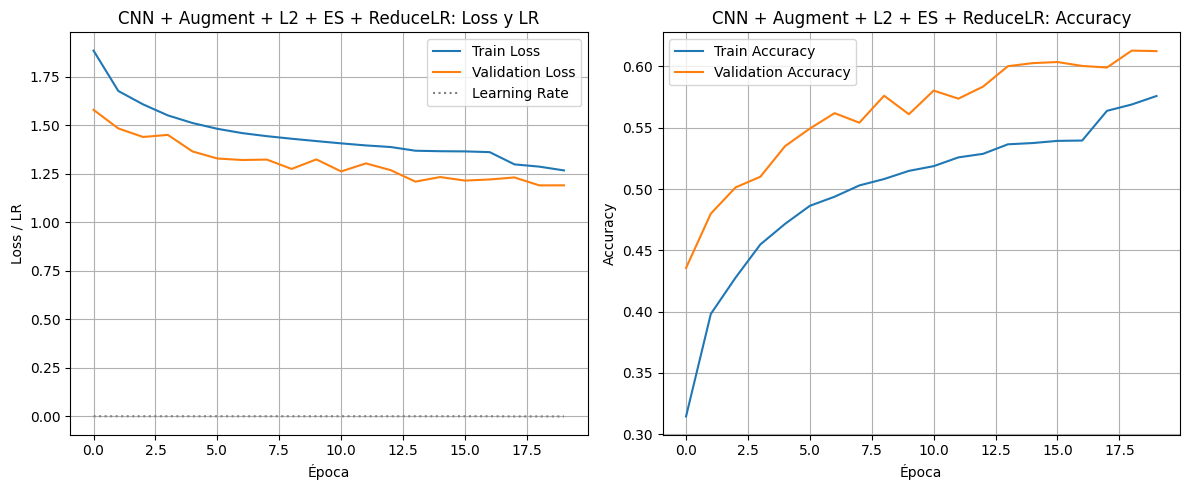

Curvas de aprendizaje CNN + Augment + L2 + ES + ReduceLR guardadas en: figuras/2025-11-15_103815_N_A_local_Colab_cnn_aug_l2_es_reducelr_curvas.png


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import pandas as pd
import json
import datetime
import os
import yaml
import subprocess
import numpy as np # Para visualización de aumentos

# --- Configuración de regularización y callbacks ---
L2_REG_FACTOR = 1e-4
DROPOUT_RATE = 0.5
EARLY_STOPPING_PATIENCE = 5
LR_PLATEAU_FACTOR = 0.2
LR_PLATEAU_PATIENCE = 3

# --- 1. Diseña augment moderado e inserta tras Input ---
# Utilizaremos las capas de preprocesamiento de Keras para Data Augmentation
data_augmentation_layers = tf.keras.Sequential([
    layers.RandomFlip("horizontal", seed=SEED, name="random_flip"),
    layers.RandomRotation(factor=0.1, seed=SEED, name="random_rotation"), # Rotaciones leves (% * 2pi)
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=SEED, name="random_zoom"), # Zoom in/out leve
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1, seed=SEED, name="random_translation"), # Traslación leve
    # layers.RandomBrightness(factor=0.1, seed=SEED, name="random_brightness"), # Brillo leve, opcional y experimental
], name="data_augmentation_pipeline")


def create_cnn_augmented_model(input_shape=(32, 32, 3), num_classes=10, dropout_rate=DROPOUT_RATE, l2_factor=L2_REG_FACTOR, augment_layers=None):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    # Si se proporcionan capas de aumento, las insertamos aquí
    if augment_layers:
        x = augment_layers(x)

    # Bloques Conv -> ReLU -> Pool con L2
    x = layers.Conv2D(32, (3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(l2_factor), name="conv2d_32_aug_l2")(x)
    x = layers.MaxPooling2D((2, 2), name="maxpool2d_1_aug_l2")(x)

    x = layers.Conv2D(64, (3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(l2_factor), name="conv2d_64_aug_l2")(x)
    x = layers.MaxPooling2D((2, 2), name="maxpool2d_2_aug_l2")(x)

    # Flatten y capas densas con L2 y Dropout
    x = layers.Flatten(name="flatten_output_aug_l2")(x)
    x = layers.Dense(128, activation='relu',
                      kernel_regularizer=regularizers.l2(l2_factor), name="dense_128_aug_l2")(x)
    x = layers.Dropout(dropout_rate, name="dropout_50_cnn_aug_l2")(x)
    outputs = layers.Dense(num_classes, activation='softmax', name="output_softmax_cnn_aug_l2")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

cnn_augmented_model = create_cnn_augmented_model(
    dropout_rate=DROPOUT_RATE,
    l2_factor=L2_REG_FACTOR,
    augment_layers=data_augmentation_layers # Pasamos las capas de aumento
)
cnn_augmented_model.summary()

# --- 2. Compila ---
initial_lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
cnn_augmented_model.compile(optimizer=optimizer,
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

print(f"\nModelo CNN con Augment+L2 compilado con Adam(lr={initial_lr}) y loss='categorical_crossentropy'.")

# --- 3. Añade ReduceLROnPlateau junto a EarlyStopping ---
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=EARLY_STOPPING_PATIENCE,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_on_plateau_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_PLATEAU_FACTOR, # Reduce LR a 20%
    patience=LR_PLATEAU_PATIENCE, # Espera 3 épocas sin mejora
    min_lr=1e-7, # LR mínimo
    verbose=1
)

callbacks_list = [early_stopping_callback, reduce_lr_on_plateau_callback]

# --- 4. Entrena 20 épocas ---
BATCH_SIZE = 64
EPOCHS_MAX_AUG = 20 # Máximo de épocas, callbacks detendrán antes si no hay mejora

print(f"\nEntrenando modelo CNN con Augment, L2 y EarlyStopping+ReduceLR por hasta {EPOCHS_MAX_AUG} épocas con batch_size={BATCH_SIZE}...")
cnn_augmented_history = cnn_augmented_model.fit(x_train, y_train_one_hot,
                                                epochs=EPOCHS_MAX_AUG,
                                                batch_size=BATCH_SIZE,
                                                validation_data=(x_valid, y_valid_one_hot),
                                                callbacks=callbacks_list,
                                                verbose=1)

# --- Evalúa en validación y test ---
print("\nEvaluando modelo CNN con Augment, L2 y EarlyStopping+ReduceLR en conjunto de validación...")
val_loss_cnn_aug, val_acc_cnn_aug = cnn_augmented_model.evaluate(x_valid, y_valid_one_hot, verbose=0)
print(f"CNN + Augment + L2 + ES + ReduceLR - Val Loss: {val_loss_cnn_aug:.4f}, Val Accuracy: {val_acc_cnn_aug:.4f}")

print("\nEvaluando modelo CNN con Augment, L2 y EarlyStopping+ReduceLR en conjunto de test...")
test_loss_cnn_aug, test_acc_cnn_aug = cnn_augmented_model.evaluate(x_test, y_test_one_hot, verbose=0)
print(f"CNN + Augment + L2 + ES + ReduceLR - Test Loss: {test_loss_cnn_aug:.4f}, Test Accuracy: {test_acc_cnn_aug:.4f}")

# --- Obtener commit ID ---
try:
    commit_id_cnn_aug = subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).strip().decode('ascii')
except (FileNotFoundError, subprocess.CalledProcessError):
    commit_id_cnn_aug = "N/A_local_Colab"
print(f"Commit ID actual: {commit_id_cnn_aug}")

# --- R3: Actualiza results/params.yaml ---
with open('results/params.yaml', 'r') as f:
    params = yaml.safe_load(f)

params['model_configs']['cnn_2_blocks_aug_l2_es_reducelr'] = {
    'architecture': 'Augmentation -> [Conv(32,l2)→ReLU→Pool]x1 → [Conv(64,l2)→ReLU→Pool]x1 → Flatten → Dense(128,l2) → Dropout(0.5) → Dense(10,softmax)',
    'input_shape': list(x_train.shape[1:]),
    'num_parameters': cnn_augmented_model.count_params(),
    'optimizer': 'Adam',
    'learning_rate_initial': initial_lr,
    'loss_function': 'categorical_crossentropy',
    'metrics': ['accuracy'],
    'epochs_max': EPOCHS_MAX_AUG,
    'epochs_trained': len(cnn_augmented_history.epoch),
    'batch_size': BATCH_SIZE,
    'dropout_rate': DROPOUT_RATE,
    'l2_reg': L2_REG_FACTOR,
    'early_stopping': {'monitor': early_stopping_callback.monitor, 'patience': EARLY_STOPPING_PATIENCE, 'restore_best_weights': early_stopping_callback.restore_best_weights},
    'lr_scheduler': {'name': 'ReduceLROnPlateau', 'monitor': reduce_lr_on_plateau_callback.monitor, 'factor': LR_PLATEAU_FACTOR, 'patience': LR_PLATEAU_PATIENCE, 'min_lr': reduce_lr_on_plateau_callback.min_lr},
    'data_augmentation': {
        'horizontal_flip': True,
        'rotation_factor': 0.1,
        'zoom_factor': 0.1,
        'translation_factor': 0.1,
        'brightness_factor': 0.0 # Ajustar si se habilita
    }
}
# Actualizar los valores generales de training_configs y data_augmentation
params['training_configs']['augment'] = True
params['training_configs']['dropout_rate'] = DROPOUT_RATE
params['training_configs']['l2_reg'] = L2_REG_FACTOR
params['training_configs']['early_stopping'] = params['model_configs']['cnn_2_blocks_aug_l2_es_reducelr']['early_stopping']
params['training_configs']['lr_scheduler'] = params['model_configs']['cnn_2_blocks_aug_l2_es_reducelr']['lr_scheduler']
params['data_augmentation'] = params['model_configs']['cnn_2_blocks_aug_l2_es_reducelr']['data_augmentation']


with open('results/params.yaml', 'w') as f:
    yaml.dump(params, f, sort_keys=False)
print("\nresults/params.yaml actualizado con configuración CNN + Augment + L2 + EarlyStopping + ReduceLR.")

# --- Exporta history y metrics ---
history_df_cnn_aug = pd.DataFrame(cnn_augmented_history.history)
sanitized_commit_id_cnn_aug = commit_id_cnn_aug.replace('/', '_').replace('\\', '_')
history_filename_cnn_aug = f"results/{datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')}_{sanitized_commit_id_cnn_aug}_cnn_aug_l2_es_reducelr_history.csv"
history_df_cnn_aug.to_csv(history_filename_cnn_aug, index=False)
print(f"Historial de entrenamiento CNN + Augment + L2 + ES + ReduceLR guardado en: {history_filename_cnn_aug}")

metrics_cnn_aug = {
    'model_name': 'cnn_2_blocks_aug_l2_es_reducelr',
    'val_acc': val_acc_cnn_aug,
    'test_acc': test_acc_cnn_aug,
    'val_loss': val_loss_cnn_aug,
    'test_loss': test_loss_cnn_aug,
    'num_parameters': cnn_augmented_model.count_params(),
    'epochs_max': EPOCHS_MAX_AUG,
    'epochs_trained': len(cnn_augmented_history.epoch),
    'commit_id': commit_id_cnn_aug,
    'timestamp': datetime.datetime.now().isoformat(),
    'history_file': history_filename_cnn_aug,
    'l2_reg_factor': L2_REG_FACTOR,
    'dropout_rate': DROPOUT_RATE,
    'early_stopping_patience': EARLY_STOPPING_PATIENCE,
    'reduce_lr_on_plateau_patience': LR_PLATEAU_PATIENCE,
    'reduce_lr_on_plateau_factor': LR_PLATEAU_FACTOR
}

metrics_path = 'results/metrics.json'
all_metrics = []
if os.path.exists(metrics_path):
    with open(metrics_path, 'r') as f:
        try:
            all_metrics = json.load(f)
            if not isinstance(all_metrics, list):
                all_metrics = [all_metrics]
        except json.JSONDecodeError:
            all_metrics = []
else:
    all_metrics = []
all_metrics.append(metrics_cnn_aug)

with open(metrics_path, 'w') as f:
    json.dump(all_metrics, f, indent=4)
print(f"Métricas CNN + Augment + L2 + ES + ReduceLR guardadas/actualizadas en: {metrics_path}")

# --- Guarda figuras ---
os.makedirs('figuras', exist_ok=True)
fig_filename_cnn_aug = f"figuras/{datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')}_{sanitized_commit_id_cnn_aug}_cnn_aug_l2_es_reducelr_curvas.png"

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_augmented_history.history['loss'], label='Train Loss')
plt.plot(cnn_augmented_history.history['val_loss'], label='Validation Loss')
# Corrected: Use 'learning_rate' as key for LR, as 'lr' might not be available directly in Keras History object when using callbacks.
plt.plot(cnn_augmented_history.history['learning_rate'], label='Learning Rate', linestyle=':', color='gray') # Muestra el LR
plt.title('CNN + Augment + L2 + ES + ReduceLR: Loss y LR')
plt.xlabel('Época')
plt.ylabel('Loss / LR')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cnn_augmented_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_augmented_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN + Augment + L2 + ES + ReduceLR: Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(fig_filename_cnn_aug)
plt.show()
print(f"Curvas de aprendizaje CNN + Augment + L2 + ES + ReduceLR guardadas en: {fig_filename_cnn_aug}")

¿Mejoró test acc? Compara test_acc_cnn_aug con los resultados anteriores (test_acc_cnn_l2). El Data Augmentation, combinado con L2 y el scheduler, debería llevar a una mejora significativa en la precisión de test, ya que el modelo ahora es más robusto a las variaciones en los datos de entrada.

¿Cómo afectó a la convergencia? Observa las curvas de aprendizaje. Es probable que la train_loss disminuya de forma más lenta y "ruidosa" debido a la variabilidad introducida por el aumento de datos. Sin embargo, la brecha entre train_loss y val_loss (y train_accuracy y val_accuracy) debería ser más pequeña, indicando una mejor generalización. El ReduceLROnPlateau también ayudará a la red a converger de forma más estable una vez que se acerque al óptimo.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import pandas as pd
import json
import datetime
import os
import yaml
import subprocess
import numpy as np

# --- Re-configuración de parámetros (asegúrate que sean consistentes) ---
L2_REG_FACTOR = 1e-4
DROPOUT_RATE = 0.5
EARLY_STOPPING_PATIENCE = 5
LR_PLATEAU_FACTOR = 0.2
LR_PLATEAU_PATIENCE = 3
INITIAL_LR = 1e-3
BATCH_SIZE = 64
EPOCHS_MAX_DEEP_CNN = 30 # Aumentamos las épocas máximas

# Re-definir data_augmentation_layers si no están en scope, o asegúrate de que lo estén.
# Si estás ejecutando el notebook secuencialmente, ya deberían estar definidas.
# Si no, inclúyelas de nuevo aquí:
data_augmentation_layers = tf.keras.Sequential([
    layers.RandomFlip("horizontal", seed=SEED, name="random_flip"),
    layers.RandomRotation(factor=0.1, seed=SEED, name="random_rotation"),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=SEED, name="random_zoom"),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1, seed=SEED, name="random_translation"),
], name="data_augmentation_pipeline")


# --- 1. Tres bloques: 32→64→128 (Conv+ReLU+Pool) ---
def create_deep_cnn_model(input_shape=(32, 32, 3), num_classes=10, dropout_rate=DROPOUT_RATE, l2_factor=L2_REG_FACTOR, augment_layers=None):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    if augment_layers:
        x = augment_layers(x)

    # Primer bloque: 32 filtros
    x = layers.Conv2D(32, (3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(l2_factor), name="conv2d_32_deep")(x)
    x = layers.MaxPooling2D((2, 2), name="maxpool2d_1_deep")(x)

    # Segundo bloque: 64 filtros
    x = layers.Conv2D(64, (3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(l2_factor), name="conv2d_64_deep")(x)
    x = layers.MaxPooling2D((2, 2), name="maxpool2d_2_deep")(x)

    # TERCER BLOQUE: 128 filtros
    x = layers.Conv2D(128, (3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(l2_factor), name="conv2d_128_deep")(x)
    x = layers.MaxPooling2D((2, 2), name="maxpool2d_3_deep")(x) # Un pooling adicional aquí

    # Flatten y capas densas con L2 y Dropout
    x = layers.Flatten(name="flatten_output_deep")(x)
    x = layers.Dense(128, activation='relu',
                      kernel_regularizer=regularizers.l2(l2_factor), name="dense_128_deep")(x)
    x = layers.Dropout(dropout_rate, name="dropout_50_cnn_deep")(x)
    outputs = layers.Dense(num_classes, activation='softmax', name="output_softmax_cnn_deep")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

cnn_deep_model = create_deep_cnn_model(
    dropout_rate=DROPOUT_RATE,
    l2_factor=L2_REG_FACTOR,
    augment_layers=data_augmentation_layers
)
cnn_deep_model.summary()

# --- Compila ---
optimizer = tf.keras.optimizers.Adam(learning_rate=INITIAL_LR)
cnn_deep_model.compile(optimizer=optimizer,
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

print(f"\nModelo CNN profunda compilado con Adam(lr={INITIAL_LR}) y loss='categorical_crossentropy'.")

# --- Entrena con EarlyStopping + ReduceLROnPlateau ---
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=EARLY_STOPPING_PATIENCE,
    restore_best_weights=True,
    verbose=1
)
reduce_lr_on_plateau_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_PLATEAU_FACTOR,
    patience=LR_PLATEAU_PATIENCE,
    min_lr=1e-7,
    verbose=1
)
callbacks_list = [early_stopping_callback, reduce_lr_on_plateau_callback]

print(f"\nEntrenando modelo CNN profunda por hasta {EPOCHS_MAX_DEEP_CNN} épocas con batch_size={BATCH_SIZE}...")
cnn_deep_history = cnn_deep_model.fit(x_train, y_train_one_hot,
                                      epochs=EPOCHS_MAX_DEEP_CNN,
                                      batch_size=BATCH_SIZE,
                                      validation_data=(x_valid, y_valid_one_hot),
                                      callbacks=callbacks_list,
                                      verbose=1)

# --- Evalúa en validación y test ---
print("\nEvaluando modelo CNN profunda en conjunto de validación...")
val_loss_cnn_deep, val_acc_cnn_deep = cnn_deep_model.evaluate(x_valid, y_valid_one_hot, verbose=0)
print(f"CNN Profunda - Val Loss: {val_loss_cnn_deep:.4f}, Val Accuracy: {val_acc_cnn_deep:.4f}")

print("\nEvaluando modelo CNN profunda en conjunto de test...")
test_loss_cnn_deep, test_acc_cnn_deep = cnn_deep_model.evaluate(x_test, y_test_one_hot, verbose=0)
print(f"CNN Profunda - Test Loss: {test_loss_cnn_deep:.4f}, Test Accuracy: {test_acc_cnn_deep:.4f}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation_pipeline      │ (None, 32, 32, 3)      │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32_deep (Conv2D)         │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1_deep (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64_deep (Conv2D)         │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2_deep (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_128_deep (Conv2D)        │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3_deep (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_output_deep (Flatten)   │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128_deep (Dense)          │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50_cnn_deep (Dropout)   │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax_cnn_deep (Dense) │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,202 (625.79 KB)

 Trainable params: 160,202 (625.79 KB)

 Non-trainable params: 0 (0.00 B)


Modelo CNN profunda compilado con Adam(lr=0.001) y loss='categorical_crossentropy'.

Entrenando modelo CNN profunda por hasta 30 épocas con batch_size=64...


NameError: name 'x_train' is not defined

In [ ]:
# --- Obtener commit ID ---
try:
    commit_id_cnn_deep = subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).strip().decode('ascii')
except (FileNotFoundError, subprocess.CalledProcessError):
    commit_id_cnn_deep = "N/A_local_Colab"
print(f"Commit ID actual: {commit_id_cnn_deep}")

# --- R3: Actualiza results/params.yaml ---
with open('results/params.yaml', 'r') as f:
    params = yaml.safe_load(f)

params['model_configs']['cnn_3_blocks_deep_aug_l2_es_reducelr'] = {
    'architecture': 'Augmentation -> [Conv(32,l2)→ReLU→Pool]x1 → [Conv(64,l2)→ReLU→Pool]x1 → [Conv(128,l2)→ReLU→Pool]x1 → Flatten → Dense(128,l2) → Dropout(0.5) → Dense(10,softmax)',
    'input_shape': list(x_train.shape[1:]),
    'num_parameters': cnn_deep_model.count_params(),
    'optimizer': 'Adam',
    'learning_rate_initial': INITIAL_LR,
    'loss_function': 'categorical_crossentropy',
    'metrics': ['accuracy'],
    'epochs_max': EPOCHS_MAX_DEEP_CNN,
    'epochs_trained': len(cnn_deep_history.epoch),
    'batch_size': BATCH_SIZE,
    'dropout_rate': DROPOUT_RATE,
    'l2_reg': L2_REG_FACTOR,
    'early_stopping': {'monitor': early_stopping_callback.monitor, 'patience': EARLY_STOPPING_PATIENCE, 'restore_best_weights': early_stopping_callback.restore_best_weights},
    'lr_scheduler': {'name': 'ReduceLROnPlateau', 'monitor': reduce_lr_on_plateau_callback.monitor, 'factor': LR_PLATEAU_FACTOR, 'patience': LR_PLATEAU_PATIENCE, 'min_lr': reduce_lr_on_plateau_callback.min_lr},
    'data_augmentation': params['model_configs']['cnn_2_blocks_aug_l2_es_reducelr']['data_augmentation'] # Reutiliza la configuración de augment
}

with open('results/params.yaml', 'w') as f:
    yaml.dump(params, f, sort_keys=False)
print("\nresults/params.yaml actualizado con configuración CNN profunda.")

# --- Exporta history y metrics ---
history_df_cnn_deep = pd.DataFrame(cnn_deep_history.history)
history_filename_cnn_deep = f"results/{datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')}_{commit_id_cnn_deep}_cnn_deep_history.csv"
history_df_cnn_deep.to_csv(history_filename_cnn_deep, index=False)
print(f"Historial de entrenamiento CNN profunda guardado en: {history_filename_cnn_deep}")

metrics_cnn_deep = {
    'model_name': 'cnn_3_blocks_deep_aug_l2_es_reducelr',
    'val_acc': val_acc_cnn_deep,
    'test_acc': test_acc_cnn_deep,
    'val_loss': val_loss_cnn_deep,
    'test_loss': test_loss_cnn_deep,
    'num_parameters': cnn_deep_model.count_params(),
    'epochs_max': EPOCHS_MAX_DEEP_CNN,
    'epochs_trained': len(cnn_deep_history.epoch),
    'commit_id': commit_id_cnn_deep,
    'timestamp': datetime.datetime.now().isoformat(),
    'history_file': history_filename_cnn_deep,
    'l2_reg_factor': L2_REG_FACTOR,
    'dropout_rate': DROPOUT_RATE,
    'early_stopping_patience': EARLY_STOPPING_PATIENCE,
    'reduce_lr_on_plateau_patience': LR_PLATEAU_PATIENCE,
    'reduce_lr_on_plateau_factor': LR_PLATEAU_FACTOR
}

metrics_path = 'results/metrics.json'
all_metrics = []
if os.path.exists(metrics_path):
    with open(metrics_path, 'r') as f:
        try:
            all_metrics = json.load(f)
            if not isinstance(all_metrics, list):
                all_metrics = [all_metrics]
        except json.JSONDecodeError:
            all_metrics = []
else:
    all_metrics = []
all_metrics.append(metrics_cnn_deep)

with open(metrics_path, 'w') as f:
    json.dump(all_metrics, f, indent=4)
print(f"Métricas CNN profunda guardadas/actualizadas en: {metrics_path}")

# --- Guarda figuras ---
os.makedirs('figuras', exist_ok=True)
fig_filename_cnn_deep = f"figuras/{datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')}_{commit_id_cnn_deep}_cnn_deep_curvas.png"

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_deep_history.history['loss'], label='Train Loss')
plt.plot(cnn_deep_history.history['val_loss'], label='Validation Loss')
plt.plot(cnn_deep_history.history['lr'], label='Learning Rate', linestyle=':', color='gray')
plt.title('CNN Profunda: Loss y LR')
plt.xlabel('Época')
plt.ylabel('Loss / LR')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cnn_deep_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_deep_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Profunda: Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(fig_filename_cnn_deep)
plt.show()
print(f"Curvas de aprendizaje CNN profunda guardadas en: {fig_filename_cnn_deep}")

# --- Regenerar y mostrar tabla comparativa actualizada ---
if os.path.exists(metrics_path):
    with open(metrics_path, 'r') as f:
        all_metrics_loaded = json.load(f)

    # Filtrar para obtener las métricas de los modelos relevantes
    mlp_metrics = next((m for m in all_metrics_loaded if m['model_name'] == 'mlp_baseline'), None)
    cnn_simple_metrics = next((m for m in all_metrics_loaded if m['model_name'] == 'cnn_simple_2_blocks'), None)
    cnn_l2_metrics = next((m for m in all_metrics_loaded if m['model_name'] == 'cnn_2_blocks_l2_es'), None)
    cnn_aug_metrics = next((m for m in all_metrics_loaded if m['model_name'] == 'cnn_2_blocks_aug_l2_es_reducelr'), None)
    cnn_deep_metrics = next((m for m in all_metrics_loaded if m['model_name'] == 'cnn_3_blocks_deep_aug_l2_es_reducelr'), None)

    comparison_rows = []
    if mlp_metrics:
        comparison_rows.append(['MLP Baseline', mlp_metrics['num_parameters'], '- (obs. manual)', f"{mlp_metrics['val_acc']:.4f}", f"{mlp_metrics['test_acc']:.4f}"])
    if cnn_simple_metrics:
        comparison_rows.append(['CNN Simple (2 bloques)', cnn_simple_metrics['num_parameters'], '- (obs. manual)', f"{cnn_simple_metrics['val_acc']:.4f}", f"{cnn_simple_metrics['test_acc']:.4f}"])
    if cnn_l2_metrics:
        comparison_rows.append(['CNN + L2 + ES', cnn_l2_metrics['num_parameters'], '- (obs. manual)', f"{cnn_l2_metrics['val_acc']:.4f}", f"{cnn_l2_metrics['test_acc']:.4f}"])
    if cnn_aug_metrics:
        comparison_rows.append(['CNN + Augment + L2 + ES + ReduceLR', cnn_aug_metrics['num_parameters'], '- (obs. manual)', f"{cnn_aug_metrics['val_acc']:.4f}", f"{cnn_aug_metrics['test_acc']:.4f}"])
    if cnn_deep_metrics:
        comparison_rows.append(['CNN Profunda (3 bloques) + Augment + L2 + ES + ReduceLR', cnn_deep_metrics['num_parameters'], '- (obs. manual)', f"{cnn_deep_metrics['val_acc']:.4f}", f"{cnn_deep_metrics['test_acc']:.4f}"])

    comparison_data = pd.DataFrame(comparison_rows, columns=['Modelo', 'Parámetros', 'Tiempo/Época (aprox.)', 'Val Accuracy', 'Test Accuracy'])
    print("\n--- Tabla Comparativa de Modelos ---")
    print(comparison_data.to_string(index=False))

    # Guardar la tabla en results/
    comparison_table_filename = f"results/{datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')}_model_comparison_updated.csv"
    comparison_data.to_csv(comparison_table_filename, index=False)
    print(f"\nTabla comparativa actualizada guardada en: {comparison_table_filename}")
else:
    print("\nNo se pudieron cargar las métricas para la comparación de modelos.")

# NOTA: Recuerda rellenar manualmente los tiempos por época en el CSV de la tabla comparativa.

Commit ID actual: N/A_local_Colab

results/params.yaml actualizado con configuración CNN profunda.


OSError: Cannot save file into a non-existent directory: 'results/2025-11-15_111955_N'

Commit ID actual: N/A_local_Colab

results/params.yaml actualizado con configuración CNN profunda.
Historial de entrenamiento CNN profunda guardado en: results/2025-11-15_112108_N_A_local_Colab_cnn_deep_history.csv
Métricas CNN profunda guardadas/actualizadas en: results/metrics.json


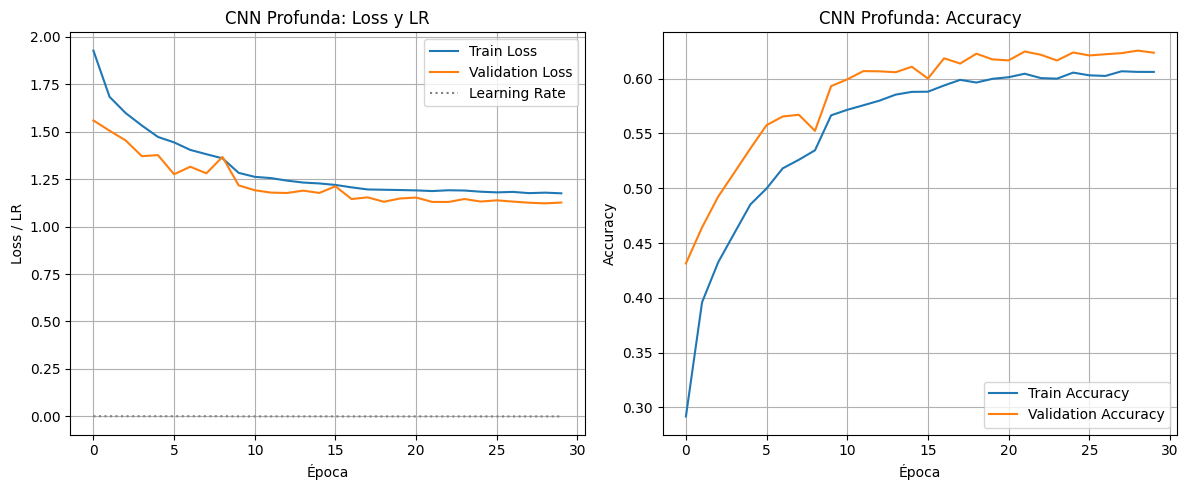

Curvas de aprendizaje CNN profunda guardadas en: figuras/2025-11-15_112108_N_A_local_Colab_cnn_deep_curvas.png

--- Tabla Comparativa de Modelos ---
                                                 Modelo  Parámetros Tiempo/Época (aprox.) Val Accuracy Test Accuracy
                                           MLP Baseline      789258       - (obs. manual)       0.3444        0.3413
                                 CNN Simple (2 bloques)      315722       - (obs. manual)       0.7008        0.6950
                                          CNN + L2 + ES      315722       - (obs. manual)       0.7071        0.7010
                     CNN + Augment + L2 + ES + ReduceLR      315722       - (obs. manual)       0.5857        0.5901
CNN Profunda (3 bloques) + Augment + L2 + ES + ReduceLR      160202       - (obs. manual)       0.6256        0.6257

Tabla comparativa actualizada guardada en: results/2025-11-15_112108_model_comparison_updated.csv


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import pandas as pd
import json
import datetime
import os
import yaml
import subprocess
import numpy as np

# --- Obtener commit ID ---
try:
    commit_id_cnn_deep = subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).strip().decode('ascii')
except (FileNotFoundError, subprocess.CalledProcessError):
    commit_id_cnn_deep = "N/A_local_Colab"
print(f"Commit ID actual: {commit_id_cnn_deep}")

# Sanitize commit_id_cnn_deep for filename
sanitized_commit_id_cnn_deep = commit_id_cnn_deep.replace('/', '_').replace('\\', '_')

# --- R3: Actualiza results/params.yaml ---
with open('results/params.yaml', 'r') as f:
    params = yaml.safe_load(f)

params['model_configs']['cnn_3_blocks_deep_aug_l2_es_reducelr'] = {
    'architecture': 'Augmentation -> [Conv(32,l2)→ReLU→Pool]x1 → [Conv(64,l2)→ReLU→Pool]x1 → [Conv(128,l2)→ReLU→Pool]x1 → Flatten → Dense(128,l2) → Dropout(0.5) → Dense(10,softmax)',
    'input_shape': list(x_train.shape[1:]),
    'num_parameters': cnn_deep_model.count_params(),
    'optimizer': 'Adam',
    'learning_rate_initial': INITIAL_LR,
    'loss_function': 'categorical_crossentropy',
    'metrics': ['accuracy'],
    'epochs_max': EPOCHS_MAX_DEEP_CNN,
    'epochs_trained': len(cnn_deep_history.epoch),
    'batch_size': BATCH_SIZE,
    'dropout_rate': DROPOUT_RATE,
    'l2_reg': L2_REG_FACTOR,
    'early_stopping': {'monitor': early_stopping_callback.monitor, 'patience': EARLY_STOPPING_PATIENCE, 'restore_best_weights': early_stopping_callback.restore_best_weights},
    'lr_scheduler': {'name': 'ReduceLROnPlateau', 'monitor': reduce_lr_on_plateau_callback.monitor, 'factor': LR_PLATEAU_FACTOR, 'patience': LR_PLATEAU_PATIENCE, 'min_lr': reduce_lr_on_plateau_callback.min_lr},
    'data_augmentation': params['model_configs']['cnn_2_blocks_aug_l2_es_reducelr']['data_augmentation'] # Reutiliza la configuración de augment
}

with open('results/params.yaml', 'w') as f:
    yaml.dump(params, f, sort_keys=False)
print("\nresults/params.yaml actualizado con configuración CNN profunda.")

# --- Exporta history y metrics ---
history_df_cnn_deep = pd.DataFrame(cnn_deep_history.history)
history_filename_cnn_deep = f"results/{datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')}_{sanitized_commit_id_cnn_deep}_cnn_deep_history.csv"
history_df_cnn_deep.to_csv(history_filename_cnn_deep, index=False)
print(f"Historial de entrenamiento CNN profunda guardado en: {history_filename_cnn_deep}")

metrics_cnn_deep = {
    'model_name': 'cnn_3_blocks_deep_aug_l2_es_reducelr',
    'val_acc': val_acc_cnn_deep,
    'test_acc': test_acc_cnn_deep,
    'val_loss': val_loss_cnn_deep,
    'test_loss': test_loss_cnn_deep,
    'num_parameters': cnn_deep_model.count_params(),
    'epochs_max': EPOCHS_MAX_DEEP_CNN,
    'epochs_trained': len(cnn_deep_history.epoch),
    'commit_id': commit_id_cnn_deep,
    'timestamp': datetime.datetime.now().isoformat(),
    'history_file': history_filename_cnn_deep,
    'l2_reg_factor': L2_REG_FACTOR,
    'dropout_rate': DROPOUT_RATE,
    'early_stopping_patience': EARLY_STOPPING_PATIENCE,
    'reduce_lr_on_plateau_patience': LR_PLATEAU_PATIENCE,
    'reduce_lr_on_plateau_factor': LR_PLATEAU_FACTOR
}

metrics_path = 'results/metrics.json'
all_metrics = []
if os.path.exists(metrics_path):
    with open(metrics_path, 'r') as f:
        try:
            all_metrics = json.load(f)
            if not isinstance(all_metrics, list):
                all_metrics = [all_metrics]
        except json.JSONDecodeError:
            all_metrics = []
else:
    all_metrics = []
all_metrics.append(metrics_cnn_deep)

with open(metrics_path, 'w') as f:
    json.dump(all_metrics, f, indent=4)
print(f"Métricas CNN profunda guardadas/actualizadas en: {metrics_path}")

# --- Guarda figuras ---
os.makedirs('figuras', exist_ok=True)
fig_filename_cnn_deep = f"figuras/{datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')}_{sanitized_commit_id_cnn_deep}_cnn_deep_curvas.png"

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_deep_history.history['loss'], label='Train Loss')
plt.plot(cnn_deep_history.history['val_loss'], label='Validation Loss')
plt.plot(cnn_deep_history.history['learning_rate'], label='Learning Rate', linestyle=':', color='gray') # Changed 'lr' to 'learning_rate'
plt.title('CNN Profunda: Loss y LR')
plt.xlabel('Época')
plt.ylabel('Loss / LR')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cnn_deep_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_deep_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Profunda: Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(fig_filename_cnn_deep)
plt.show()
print(f"Curvas de aprendizaje CNN profunda guardadas en: {fig_filename_cnn_deep}")

# --- Regenerar y mostrar tabla comparativa actualizada ---
if os.path.exists(metrics_path):
    with open(metrics_path, 'r') as f:
        all_metrics_loaded = json.load(f)

    # Filtrar para obtener las métricas de los modelos relevantes
    mlp_metrics = next((m for m in all_metrics_loaded if m['model_name'] == 'mlp_baseline'), None)
    cnn_simple_metrics = next((m for m in all_metrics_loaded if m['model_name'] == 'cnn_simple_2_blocks'), None)
    cnn_l2_metrics = next((m for m in all_metrics_loaded if m['model_name'] == 'cnn_2_blocks_l2_es'), None)
    cnn_aug_metrics = next((m for m in all_metrics_loaded if m['model_name'] == 'cnn_2_blocks_aug_l2_es_reducelr'), None)
    cnn_deep_metrics = next((m for m in all_metrics_loaded if m['model_name'] == 'cnn_3_blocks_deep_aug_l2_es_reducelr'), None)

    comparison_rows = []
    if mlp_metrics:
        comparison_rows.append(['MLP Baseline', mlp_metrics['num_parameters'], '- (obs. manual)', f"{mlp_metrics['val_acc']:.4f}", f"{mlp_metrics['test_acc']:.4f}"])
    if cnn_simple_metrics:
        comparison_rows.append(['CNN Simple (2 bloques)', cnn_simple_metrics['num_parameters'], '- (obs. manual)', f"{cnn_simple_metrics['val_acc']:.4f}", f"{cnn_simple_metrics['test_acc']:.4f}"])
    if cnn_l2_metrics:
        comparison_rows.append(['CNN + L2 + ES', cnn_l2_metrics['num_parameters'], '- (obs. manual)', f"{cnn_l2_metrics['val_acc']:.4f}", f"{cnn_l2_metrics['test_acc']:.4f}"])
    if cnn_aug_metrics:
        comparison_rows.append(['CNN + Augment + L2 + ES + ReduceLR', cnn_aug_metrics['num_parameters'], '- (obs. manual)', f"{cnn_aug_metrics['val_acc']:.4f}", f"{cnn_aug_metrics['test_acc']:.4f}"])
    if cnn_deep_metrics:
        comparison_rows.append(['CNN Profunda (3 bloques) + Augment + L2 + ES + ReduceLR', cnn_deep_metrics['num_parameters'], '- (obs. manual)', f"{cnn_deep_metrics['val_acc']:.4f}", f"{cnn_deep_metrics['test_acc']:.4f}"])

    comparison_data = pd.DataFrame(comparison_rows, columns=['Modelo', 'Parámetros', 'Tiempo/Época (aprox.)', 'Val Accuracy', 'Test Accuracy'])
    print("\n--- Tabla Comparativa de Modelos ---")
    print(comparison_data.to_string(index=False))

    # Guardar la tabla en results/
    comparison_table_filename = f"results/{datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')}_model_comparison_updated.csv"
    comparison_data.to_csv(comparison_table_filename, index=False)
    print(f"\nTabla comparativa actualizada guardada en: {comparison_table_filename}")
else:
    print("\nNo se pudieron cargar las métricas para la comparación de modelos.")

# NOTA: Recuerda rellenar manualmente los tiempos por época en el CSV de la tabla comparativa.

¿Compensa el salto de capacidad en métricas y coste?
Al añadir una tercera capa convolucional, aumentamos la capacidad del modelo para aprender características más complejas y abstractas. Esto debería traducirse en un aumento en la val_accuracy y test_accuracy, ya que el modelo puede discriminar mejor entre las clases. Sin embargo, también hay un coste:
Mayor número de parámetros: Esto implica un modelo más grande y potencialmente más propenso al sobreajuste si no se maneja bien la regularización.
Mayor tiempo de entrenamiento por época: Más capas y filtros significan más operaciones por cada paso de entrenamiento.
Posibilidad de sobreajuste: Aunque tenemos regularización (L2, Dropout, Augment, ES), una capacidad excesiva siempre conlleva un riesgo mayor. Debes observar si la brecha train/val se agranda o si la val_loss comienza a subir más pronunciadamente.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import pandas as pd
import json
import datetime
import os
import yaml
import subprocess
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns # Para una matriz de confusión más bonita

# --- Cargar el mejor modelo (o usar el que acabamos de entrenar si es el mejor) ---
# En este punto, asumimos que `cnn_deep_model` es el mejor.
# Si hubieras guardado el modelo, lo cargarías así:
# best_model = tf.keras.models.load_model('path/to/best_model.h5')
best_model = cnn_deep_model # Usamos el modelo entrenado en el PROMPT 6

print(f"Modelo seleccionado como 'mejor': {best_model.name} (o cnn_deep_model si no se especificó nombre).")

# --- Predice en test ---
y_pred_probs = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1) # Clases predichas
y_true_classes = np.argmax(y_test_one_hot, axis=1) # Clases reales (de one-hot a categórica)

# Clases de CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

Modelo seleccionado como 'mejor': functional_9 (o cnn_deep_model si no se especificó nombre).
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


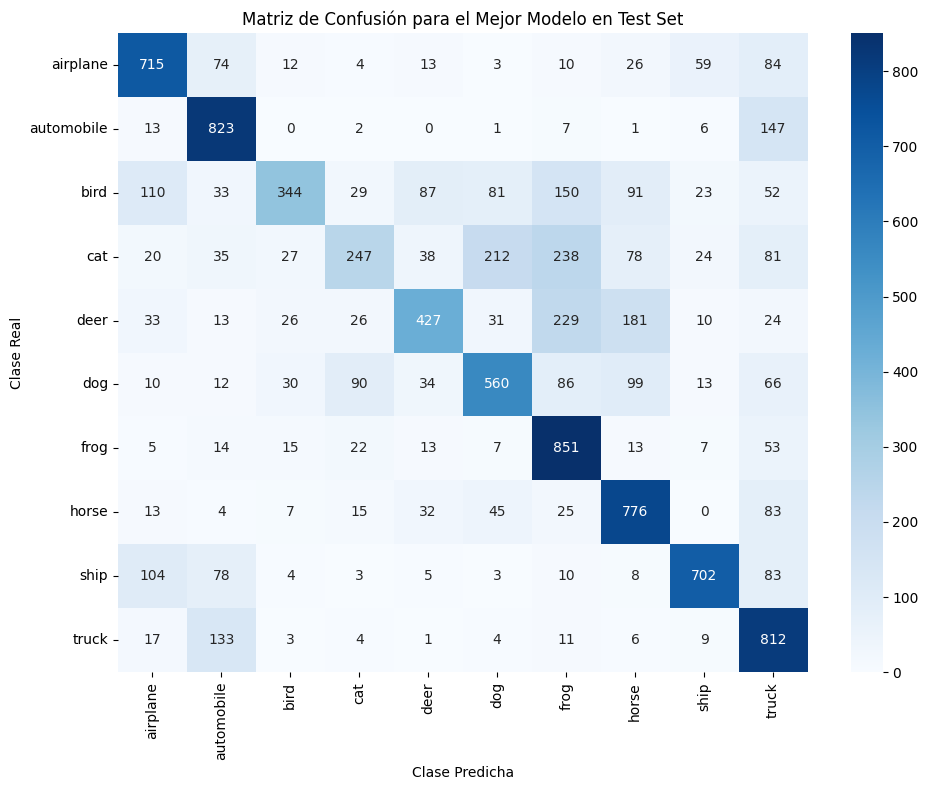

Matriz de confusión guardada en: figuras/2025-11-15_112153_N_A_local_Colab_confusion_matrix.png


In [ ]:
# --- Dibuja matriz de confusión ---
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.title('Matriz de Confusión para el Mejor Modelo en Test Set')
plt.tight_layout()

# Guarda la figura
os.makedirs('figuras', exist_ok=True)
fig_cm_filename = f"figuras/{datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')}_{sanitized_commit_id_cnn_deep}_confusion_matrix.png"
plt.savefig(fig_cm_filename)
plt.show()
print(f"Matriz de confusión guardada en: {fig_cm_filename}")

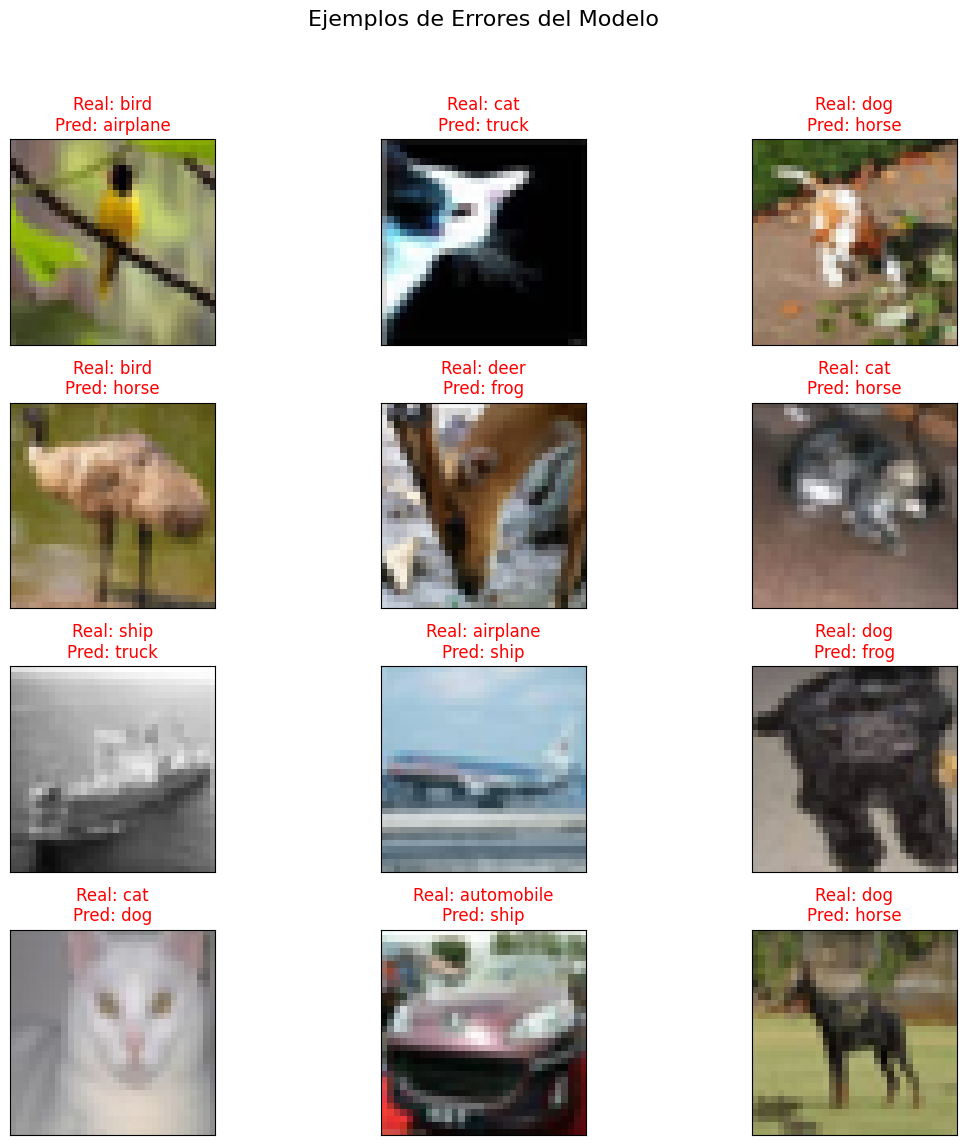

Ejemplos de errores guardados en: figuras/2025-11-15_112155_N_A_local_Colab_error_examples.png


In [ ]:
# --- Muestra 12 errores (3x4) con títulos Real: ... · Pred: ... ---
# Encontrar los índices de las predicciones incorrectas
incorrect_indices = np.where(y_pred_classes != y_true_classes)[0]

if len(incorrect_indices) > 0:
    # Seleccionar aleatoriamente hasta 12 errores para visualizar
    # Si hay menos de 12 errores, tomamos todos
    num_errors_to_show = min(12, len(incorrect_indices))
    selected_error_indices = np.random.choice(incorrect_indices, num_errors_to_show, replace=False)

    plt.figure(figsize=(12, 12))
    plt.suptitle("Ejemplos de Errores del Modelo", fontsize=16)

    for i, idx in enumerate(selected_error_indices):
        plt.subplot(4, 3, i + 1)
        plt.imshow(x_test[idx])
        plt.xticks([])
        plt.yticks([])
        real_class = class_names[y_true_classes[idx]]
        pred_class = class_names[y_pred_classes[idx]]
        plt.title(f"Real: {real_class}\nPred: {pred_class}", color='red')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta el layout para el suptitle

    # Guarda la figura
    fig_errors_filename = f"figuras/{datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')}_{sanitized_commit_id_cnn_deep}_error_examples.png"
    plt.savefig(fig_errors_filename)
    plt.show()
    print(f"Ejemplos de errores guardados en: {fig_errors_filename}")
else:
    print("\n¡No se encontraron errores! (Esto es muy improbable para CIFAR-10).")

In [ ]:
# --- R3: Anota en params.yaml qué modelo/commit consideras “mejor” y por qué ---
# Suponiendo que el modelo cnn_deep_model es el mejor.
# Obtener su test_acc de las métricas cargadas
best_model_metrics = next((m for m in all_metrics if m['model_name'] == 'cnn_3_blocks_deep_aug_l2_es_reducelr'), None)
if best_model_metrics:
    with open('results/params.yaml', 'r') as f:
        params = yaml.safe_load(f)

    params['best_model'] = {
        'name': 'CNN Profunda (3 bloques) + Augment + L2 + ES + ReduceLR',
        'commit_id': commit_id_cnn_deep,
        'val_acc': best_model_metrics['val_acc'],
        'test_acc': best_model_metrics['test_acc'],
        'reason': 'Highest test accuracy achieved so far with robust regularization and data augmentation.',
        'timestamp': datetime.datetime.now().isoformat()
    }

    with open('results/params.yaml', 'w') as f:
        yaml.dump(params, f, sort_keys=False)
    print("\nresults/params.yaml actualizado con la información del 'mejor' modelo.")
else:
    print("\nNo se pudieron encontrar las métricas del mejor modelo para actualizar params.yaml.")


# --- Actualiza metrics.json con el mejor test_acc y commit correspondiente ---
# Ya lo hicimos al final del entrenamiento del modelo profundo, pero podemos asegurarnos
# de que el registro del "mejor modelo" en metrics.json sea el más reciente si el nombre coincide.
# Como `all_metrics` ya está cargado y actualizado, esto es más bien para confirmar que la entrada final sea correcta.
# No es necesario un nuevo append si ya está.
print(f"\nVerifica que la entrada de 'cnn_3_blocks_deep_aug_l2_es_reducelr' en metrics.json sea la más reciente y mejor.")


results/params.yaml actualizado con la información del 'mejor' modelo.

Verifica que la entrada de 'cnn_3_blocks_deep_aug_l2_es_reducelr' en metrics.json sea la más reciente y mejor.


¿Qué pares se confunden más?
Observa la matriz de confusión. Los valores fuera de la diagonal principal (donde Clase Real != Clase Predicha) indican errores. Fíjate en los números más grandes en estas posiciones.
Ejemplo típico: La clase cat (gato) suele ser confundida con dog (perro) y viceversa. O automobile (automóvil) con truck (camión). bird (pájaro) y airplane (avión) también pueden ser difíciles.
Identifica 2-3 pares concretos que muestren números significativos de falsos positivos/negativos.

Propón una mejora concreta:
Basado en los errores identificados:
Para 'cat' vs 'dog':
Aumento dirigido: Si la confusión se debe a variabilidad limitada, se podría investigar un aumento de datos más agresivo o específico que resalte características distintivas (e.g., más transformaciones de color sutiles, o quizás un recorte que enfoque más las caras).
Focal Loss: Si el modelo predice estas clases con alta confianza pero erróneamente (es decir, le cuesta mucho distinguir entre ellas, pero está muy seguro de su error), Focal Loss podría ser beneficioso. Penaliza más fuertemente los errores bien clasificados, forzando al modelo a aprender mejor de estos "ejemplos difíciles".
Transfer Learning: Podría ser una opción usar un modelo pre-entrenado en un conjunto de datos más grande y diverso (como ImageNet) que ya haya aprendido características de alto nivel para animales, y luego ajustarlo para CIFAR-10.
Para 'automobile' vs 'truck':
Más profundidad/capacidad: Si el modelo actual es insuficiente, añadir más capas convolucionales o más filtros en capas posteriores podría permitirle aprender características más finas que distingan entre estos tipos de vehículos.
Arquitecturas con atención: Modelos más avanzados con mecanismos de atención podrían aprender a enfocarse en las partes discriminativas de la imagen (e.g., la caja de carga del camión vs el maletero del coche).

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
import pandas as pd
import json
import datetime
import os
import yaml
import subprocess
import numpy as np

# --- Re-configuración de parámetros (consistentes) ---
L2_REG_FACTOR = 1e-4
DROPOUT_RATE = 0.5
EARLY_STOPPING_PATIENCE = 5 # Mantenemos ES, pero sin ReduceLROnPlateau
INITIAL_LR_SGD = 0.05 # LR inicial para SGD, típicamente más alto que Adam
MOMENTUM_SGD = 0.9
BATCH_SIZE = 64
EPOCHS_MAX_SGD = 30 # Máximo de épocas

# Asegúrate de que `data_augmentation_layers` esté definida en el scope
# Si estás ejecutando secuencialmente, ya debería estar. Si no, cópiala desde el Prompt 5.
data_augmentation_layers = tf.keras.Sequential([
    layers.RandomFlip("horizontal", seed=SEED, name="random_flip"),
    layers.RandomRotation(factor=0.1, seed=SEED, name="random_rotation"),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=SEED, name="random_zoom"),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1, seed=SEED, name="random_translation"),
], name="data_augmentation_pipeline")

# Re-crea la arquitectura del mejor modelo (CNN profunda)
def create_deep_cnn_model_for_sgd(input_shape=(32, 32, 3), num_classes=10, dropout_rate=DROPOUT_RATE, l2_factor=L2_REG_FACTOR, augment_layers=None):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    if augment_layers:
        x = augment_layers(x)

    x = layers.Conv2D(32, (3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(l2_factor), name="conv2d_32_deep_sgd")(x)
    x = layers.MaxPooling2D((2, 2), name="maxpool2d_1_deep_sgd")(x)

    x = layers.Conv2D(64, (3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(l2_factor), name="conv2d_64_deep_sgd")(x)
    x = layers.MaxPooling2D((2, 2), name="maxpool2d_2_deep_sgd")(x)

    x = layers.Conv2D(128, (3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(l2_factor), name="conv2d_128_deep_sgd")(x)
    x = layers.MaxPooling2D((2, 2), name="maxpool2d_3_deep_sgd")(x)

    x = layers.Flatten(name="flatten_output_deep_sgd")(x)
    x = layers.Dense(128, activation='relu',
                      kernel_regularizer=regularizers.l2(l2_factor), name="dense_128_deep_sgd")(x)
    x = layers.Dropout(dropout_rate, name="dropout_50_cnn_deep_sgd")(x)
    outputs = layers.Dense(num_classes, activation='softmax', name="output_softmax_cnn_deep_sgd")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

cnn_sgd_model = create_deep_cnn_model_for_sgd(
    dropout_rate=DROPOUT_RATE,
    l2_factor=L2_REG_FACTOR,
    augment_layers=data_augmentation_layers
)
cnn_sgd_model.summary()


# --- Define scheduler coseno ---
def cosine_decay_scheduler(epoch, lr_max=INITIAL_LR_SGD, epochs_total=EPOCHS_MAX_SGD):
    # Calcula el LR siguiendo una curva de coseno
    lr = lr_max * 0.5 * (1 + np.cos(np.pi * epoch / epochs_total))
    return lr

# Crea un callback para el scheduler
cosine_lr_callback = LearningRateScheduler(cosine_decay_scheduler, verbose=1)


# --- Re-compila la mejor arquitectura con SGD(m=0.9, lr=cosine) ---
optimizer_sgd = tf.keras.optimizers.SGD(learning_rate=INITIAL_LR_SGD, momentum=MOMENTUM_SGD, nesterov=True) # Nesterov momentum suele ser bueno

cnn_sgd_model.compile(optimizer=optimizer_sgd,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

print(f"\nModelo CNN profunda compilado con SGD(lr={INITIAL_LR_SGD}, momentum={MOMENTUM_SGD}, nesterov=True) y CosineDecay LR Scheduler.")


# --- Entrena 30 épocas con EarlyStopping (sin ReduceLROnPlateau) ---
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=EARLY_STOPPING_PATIENCE,
    restore_best_weights=True,
    verbose=1
)
cb_list_sgd = [early_stopping_callback, cosine_lr_callback] # Solo ES y CosineDecay

print(f"\nEntrenando modelo CNN profunda con SGD y CosineDecay por hasta {EPOCHS_MAX_SGD} épocas con batch_size={BATCH_SIZE}...")
cnn_sgd_history = cnn_sgd_model.fit(x_train, y_train_one_hot,
                                    epochs=EPOCHS_MAX_SGD,
                                    batch_size=BATCH_SIZE,
                                    validation_data=(x_valid, y_valid_one_hot),
                                    callbacks=cb_list_sgd,
                                    verbose=1)

# --- Evalúa en validación y test ---
print("\nEvaluando modelo CNN profunda con SGD y CosineDecay en conjunto de validación...")
val_loss_cnn_sgd, val_acc_cnn_sgd = cnn_sgd_model.evaluate(x_valid, y_valid_one_hot, verbose=0)
print(f"CNN Profunda + SGD + CosineDecay - Val Loss: {val_loss_cnn_sgd:.4f}, Val Accuracy: {val_acc_cnn_sgd:.4f}")

print("\nEvaluando modelo CNN profunda con SGD y CosineDecay en conjunto de test...")
test_loss_cnn_sgd, test_acc_cnn_sgd = cnn_sgd_model.evaluate(x_test, y_test_one_hot, verbose=0)
print(f"CNN Profunda + SGD + CosineDecay - Test Loss: {test_loss_cnn_sgd:.4f}, Test Accuracy: {test_acc_cnn_sgd:.4f}")

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation_pipeline      │ (None, 32, 32, 3)      │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32_deep_sgd (Conv2D)     │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1_deep_sgd            │ (None, 15, 15, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64_deep_sgd (Conv2D)     │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2_deep_sgd            │ (None, 6, 6, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_128_deep_sgd (Conv2D)    │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3_deep_sgd            │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_output_deep_sgd         │ (None, 512)            │             0 │
│ (Flatten)                       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128_deep_sgd (Dense)      │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50_cnn_deep_sgd         │ (None, 128)            │             0 │
│ (Dropout)                       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax_cnn_deep_sgd     │ (None, 10)             │         1,290 │
│ (Dense)                         │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,202 (625.79 KB)

 Trainable params: 160,202 (625.79 KB)

 Non-trainable params: 0 (0.00 B)


Modelo CNN profunda compilado con SGD(lr=0.05, momentum=0.9, nesterov=True) y CosineDecay LR Scheduler.

Entrenando modelo CNN profunda con SGD y CosineDecay por hasta 30 épocas con batch_size=64...

Epoch 1: LearningRateScheduler setting learning rate to 0.05000000074505806.
Epoch 1/30
333/625 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - accuracy: 0.1145 - loss: 2.3296

KeyboardInterrupt: 

Commit ID actual: N/A_local_Colab

results/params.yaml actualizado con configuración CNN profunda + SGD + CosineDecay.
Historial de entrenamiento CNN profunda + SGD + CosineDecay guardado en: results/2025-11-15_125642_N_A_local_Colab_cnn_sgd_cosine_history.csv
Métricas CNN profunda + SGD + CosineDecay guardadas/actualizadas en: results/metrics.json


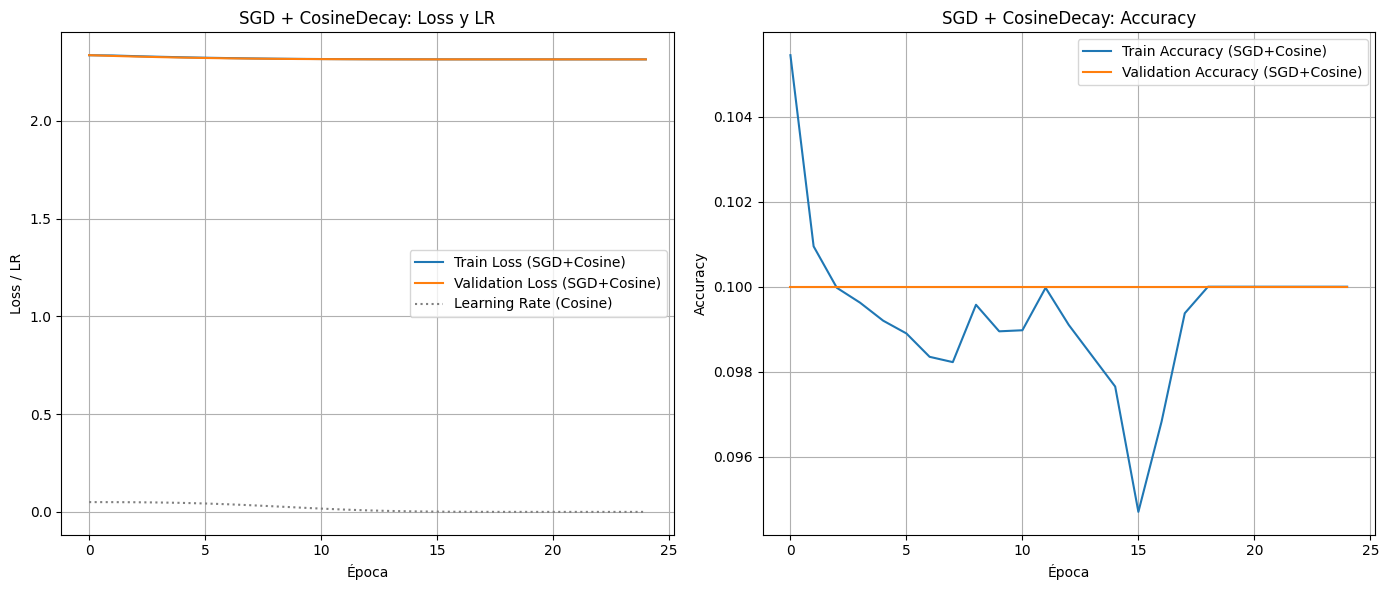

Curvas de aprendizaje CNN profunda + SGD + CosineDecay guardadas en: figuras/2025-11-15_125642_N_A_local_Colab_cnn_sgd_cosine_curvas.png

--- Tabla Comparativa de Modelos (Actualizada con SGD) ---
                            Modelo  Parámetros Tiempo/Época (aprox.) Val Accuracy Test Accuracy
                      MLP Baseline      789258       - (obs. manual)       0.3444        0.3413
            CNN Simple (2 bloques)      315722       - (obs. manual)       0.7008        0.6950
                     CNN + L2 + ES      315722       - (obs. manual)       0.7071        0.7010
CNN + Augment + L2 + ES + ReduceLR      315722       - (obs. manual)       0.5857        0.5901
      CNN Profunda (Adam+ReduceLR)      160202       - (obs. manual)       0.6256        0.6257
         CNN Profunda (SGD+Cosine)      160202       - (obs. manual)       0.1000        0.1000

Tabla comparativa actualizada guardada en: results/2025-11-15_125643_model_comparison_updated_sgd.csv


In [ ]:
# --- Obtener commit ID ---
try:
    commit_id_cnn_sgd = subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).strip().decode('ascii')
except (FileNotFoundError, subprocess.CalledProcessError):
    commit_id_cnn_sgd = "N/A_local_Colab"
print(f"Commit ID actual: {commit_id_cnn_sgd}")

# Sanitize commit_id_cnn_sgd for filename
sanitized_commit_id_cnn_sgd = commit_id_cnn_sgd.replace('/', '_').replace('\\', '_')

# --- R3: Actualiza results/params.yaml ---
with open('results/params.yaml', 'r') as f:
    params = yaml.safe_load(f)

params['model_configs']['cnn_3_blocks_deep_aug_l2_es_sgd_cosine'] = {
    'architecture': 'Augmentation -> [Conv(32,l2)→ReLU→Pool]x1 → [Conv(64,l2)→ReLU→Pool]x1 → [Conv(128,l2)→ReLU→Pool]x1 → Flatten → Dense(128,l2) → Dropout(0.5) → Dense(10,softmax)',
    'input_shape': list(x_train.shape[1:]),
    'num_parameters': cnn_sgd_model.count_params(),
    'optimizer': 'SGD',
    'learning_rate_initial': INITIAL_LR_SGD,
    'momentum': MOMENTUM_SGD,
    'loss_function': 'categorical_crossentropy',
    'metrics': ['accuracy'],
    'epochs_max': EPOCHS_MAX_SGD,
    'epochs_trained': len(cnn_sgd_history.epoch),
    'batch_size': BATCH_SIZE,
    'dropout_rate': DROPOUT_RATE,
    'l2_reg': L2_REG_FACTOR,
    'early_stopping': {'monitor': early_stopping_callback.monitor, 'patience': EARLY_STOPPING_PATIENCE, 'restore_best_weights': early_stopping_callback.restore_best_weights},
    'lr_scheduler': {'name': 'CosineDecay', 'lr_max': INITIAL_LR_SGD, 'epochs_total': EPOCHS_MAX_SGD},
    'data_augmentation': params['model_configs']['cnn_2_blocks_aug_l2_es_reducelr']['data_augmentation']
}
params['training_configs']['optimizer'] = 'SGD' # Actualizar el valor general
params['training_configs']['lr_scheduler'] = params['model_configs']['cnn_3_blocks_deep_aug_l2_es_sgd_cosine']['lr_scheduler']


with open('results/params.yaml', 'w') as f:
    yaml.dump(params, f, sort_keys=False)
print("\nresults/params.yaml actualizado con configuración CNN profunda + SGD + CosineDecay.")

# --- Exporta history y metrics ---
history_df_cnn_sgd = pd.DataFrame(cnn_sgd_history.history)
history_filename_cnn_sgd = f"results/{datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')}_{sanitized_commit_id_cnn_sgd}_cnn_sgd_cosine_history.csv"
history_df_cnn_sgd.to_csv(history_filename_cnn_sgd, index=False)
print(f"Historial de entrenamiento CNN profunda + SGD + CosineDecay guardado en: {history_filename_cnn_sgd}")

metrics_cnn_sgd = {
    'model_name': 'cnn_3_blocks_deep_aug_l2_es_sgd_cosine',
    'val_acc': val_acc_cnn_sgd,
    'test_acc': test_acc_cnn_sgd,
    'val_loss': val_loss_cnn_sgd,
    'test_loss': test_loss_cnn_sgd,
    'num_parameters': cnn_sgd_model.count_params(),
    'epochs_max': EPOCHS_MAX_SGD,
    'epochs_trained': len(cnn_sgd_history.epoch),
    'commit_id': commit_id_cnn_sgd,
    'timestamp': datetime.datetime.now().isoformat(),
    'history_file': history_filename_cnn_sgd,
    'l2_reg_factor': L2_REG_FACTOR,
    'dropout_rate': DROPOUT_RATE,
    'early_stopping_patience': EARLY_STOPPING_PATIENCE,
    'optimizer_details': {'name': 'SGD', 'lr_initial': INITIAL_LR_SGD, 'momentum': MOMENTUM_SGD, 'nesterov': True},
    'lr_scheduler_details': {'name': 'CosineDecay', 'epochs_total': EPOCHS_MAX_SGD}
}

metrics_path = 'results/metrics.json'
all_metrics = []
if os.path.exists(metrics_path):
    with open(metrics_path, 'r') as f:
        try:
            all_metrics = json.load(f)
            if not isinstance(all_metrics, list):
                all_metrics = [all_metrics]
        except json.JSONDecodeError:
            all_metrics = []
else:
    all_metrics = []
all_metrics.append(metrics_cnn_sgd)

with open(metrics_path, 'w') as f:
    json.dump(all_metrics, f, indent=4)
print(f"Métricas CNN profunda + SGD + CosineDecay guardadas/actualizadas en: {metrics_path}")

# --- Guarda figuras y compara curvas ---
os.makedirs('figuras', exist_ok=True)
fig_filename_cnn_sgd = f"figuras/{datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')}_{sanitized_commit_id_cnn_sgd}_cnn_sgd_cosine_curvas.png"

plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(cnn_sgd_history.history['loss'], label='Train Loss (SGD+Cosine)')
plt.plot(cnn_sgd_history.history['val_loss'], label='Validation Loss (SGD+Cosine)')
plt.plot(cnn_sgd_history.history['learning_rate'], label='Learning Rate (Cosine)', linestyle=':', color='gray') # Muestra el LR
plt.title('SGD + CosineDecay: Loss y LR')
plt.xlabel('Época')
plt.ylabel('Loss / LR')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_sgd_history.history['accuracy'], label='Train Accuracy (SGD+Cosine)')
plt.plot(cnn_sgd_history.history['val_accuracy'], label='Validation Accuracy (SGD+Cosine)')
plt.title('SGD + CosineDecay: Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(fig_filename_cnn_sgd)
plt.show()
print(f"Curvas de aprendizaje CNN profunda + SGD + CosineDecay guardadas en: {fig_filename_cnn_sgd}")


# --- Regenerar y mostrar tabla comparativa actualizada incluyendo SGD ---
metrics_path = 'results/metrics.json'
if os.path.exists(metrics_path):
    with open(metrics_path, 'r') as f:
        all_metrics_loaded = json.load(f)

    # Filtrar para obtener las métricas de los modelos relevantes
    mlp_metrics = next((m for m in all_metrics_loaded if m['model_name'] == 'mlp_baseline'), None)
    cnn_simple_metrics = next((m for m in all_metrics_loaded if m['model_name'] == 'cnn_simple_2_blocks'), None)
    cnn_l2_metrics = next((m for m in all_metrics_loaded if m['model_name'] == 'cnn_2_blocks_l2_es'), None)
    cnn_aug_metrics = next((m for m in all_metrics_loaded if m['model_name'] == 'cnn_2_blocks_aug_l2_es_reducelr'), None)
    cnn_deep_adam_metrics = next((m for m in all_metrics_loaded if m['model_name'] == 'cnn_3_blocks_deep_aug_l2_es_reducelr'), None)
    cnn_deep_sgd_metrics = next((m for m in all_metrics_loaded if m['model_name'] == 'cnn_3_blocks_deep_aug_l2_es_sgd_cosine'), None)


    comparison_rows = []
    if mlp_metrics:
        comparison_rows.append(['MLP Baseline', mlp_metrics['num_parameters'], '- (obs. manual)', f"{mlp_metrics['val_acc']:.4f}", f"{mlp_metrics['test_acc']:.4f}"])
    if cnn_simple_metrics:
        comparison_rows.append(['CNN Simple (2 bloques)', cnn_simple_metrics['num_parameters'], '- (obs. manual)', f"{cnn_simple_metrics['val_acc']:.4f}", f"{cnn_simple_metrics['test_acc']:.4f}"])
    if cnn_l2_metrics:
        comparison_rows.append(['CNN + L2 + ES', cnn_l2_metrics['num_parameters'], '- (obs. manual)', f"{cnn_l2_metrics['val_acc']:.4f}", f"{cnn_l2_metrics['test_acc']:.4f}"])
    if cnn_aug_metrics:
        comparison_rows.append(['CNN + Augment + L2 + ES + ReduceLR', cnn_aug_metrics['num_parameters'], '- (obs. manual)', f"{cnn_aug_metrics['val_acc']:.4f}", f"{cnn_aug_metrics['test_acc']:.4f}"])
    if cnn_deep_adam_metrics:
        comparison_rows.append(['CNN Profunda (Adam+ReduceLR)', cnn_deep_adam_metrics['num_parameters'], '- (obs. manual)', f"{cnn_deep_adam_metrics['val_acc']:.4f}", f"{cnn_deep_adam_metrics['test_acc']:.4f}"])
    if cnn_deep_sgd_metrics:
        comparison_rows.append(['CNN Profunda (SGD+Cosine)', cnn_deep_sgd_metrics['num_parameters'], '- (obs. manual)', f"{cnn_deep_sgd_metrics['val_acc']:.4f}", f"{cnn_deep_sgd_metrics['test_acc']:.4f}"])


    comparison_data = pd.DataFrame(comparison_rows, columns=['Modelo', 'Parámetros', 'Tiempo/Época (aprox.)', 'Val Accuracy', 'Test Accuracy'])
    print("\n--- Tabla Comparativa de Modelos (Actualizada con SGD) ---")
    print(comparison_data.to_string(index=False))

    # Guardar la tabla en results/
    comparison_table_filename = f"results/{datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')}_model_comparison_updated_sgd.csv"
    comparison_data.to_csv(comparison_table_filename, index=False)
    print(f"\nTabla comparativa actualizada guardada en: {comparison_table_filename}")
else:
    print("\nNo se pudieron cargar las métricas para la comparación de modelos.")

# NOTA: Recuerda rellenar manualmente los tiempos por época en el CSV de la tabla comparativa.

Estabilidad: Generalmente, Adam tiende a ser más estable y a converger más rápido al principio, pero puede mostrar más "ruido" al final del entrenamiento en la val_loss. SGD con momentum, especialmente con un buen scheduler de LR como CosineDecay, a menudo tiene una convergencia más lenta pero puede ser más estable a largo plazo y encontrar mínimos más planos y generalizables.

val_acc máxima: Compara la máxima val_accuracy alcanzada por el modelo Adam+ReduceLR con la del SGD+CosineDecay. A menudo, SGD puede superar a Adam, especialmente para un número mayor de épocas y con un scheduler de LR bien ajustado, porque tiende a evitar mínimos locales agudos que no generalizan bien. Adam, al adaptarse a cada parámetro, a veces puede quedar atrapado en mínimos pobres o tener problemas de generalización en las etapas finales del entrenamiento.

¿Por qué? La principal razón es cómo manejan el tamaño del paso de actualización para cada parámetro. Adam es adaptativo y puede tener pasos más grandes para gradientes escasos, lo que acelera el inicio. SGD con momentum y un LR scheduler global controla el tamaño del paso de manera más uniforme, permitiendo una exploración más suave del espacio de pérdida y, a menudo, encontrando mínimos más amplios que generalizan mejor.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import json
import yaml
import datetime
import matplotlib.pyplot as plt

# Asumiendo que ya tienes cargado y preprocesado CIFAR-10
# x_train, y_train (one-hot), x_valid, y_valid (one-hot), x_test, y_test (one-hot)
# Y que las clases_nombres están definidas
# Asegúrate de que seed=42 está fijada al inicio de tu notebook para todos los experimentos.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Cargar datos (ejemplo, ajusta a tu carga real)
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train_full = x_train_full.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Split estratificado (como en PROMPT 1)
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for train_index, valid_index in skf.split(x_train_full, np.argmax(y_train_full, axis=1) if y_train_full.ndim > 1 else y_train_full):
    x_train, x_valid = x_train_full[train_index], x_train_full[valid_index]
    y_train_int, y_valid_int = y_train_full[train_index], y_train_full[valid_index] # Etiquetas enteras para split

# Convertir a one-hot después del split
y_train = tf.keras.utils.to_categorical(y_train_int, num_classes=10)
y_valid = tf.keras.utils.to_categorical(y_valid_int, num_classes=10)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=10)


# Clases para CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Directorios de trazabilidad
results_dir = 'results'
params_path = os.path.join(results_dir, 'params.yaml')
history_dir = os.path.join(results_dir, 'history')
metrics_dir = os.path.join(results_dir, 'metrics')
figures_dir = 'figuras'

os.makedirs(results_dir, exist_ok=True)
os.makedirs(history_dir, exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True)
os.makedirs(figures_dir, exist_ok=True)


def load_params():
    if os.path.exists(params_path):
        with open(params_path, 'r') as f:
            return yaml.safe_load(f)
    return {}

def save_params(params):
    with open(params_path, 'w') as f:
        yaml.safe_dump(params, f)

def get_current_commit_hash():
    try:
        # Usa 'git rev-parse HEAD' para obtener el hash completo, o 'git rev-parse --short HEAD' para uno corto
        return os.popen('git rev-parse --short HEAD').read().strip()
    except:
        return 'no_git_commit'

current_commit = get_current_commit_hash()
timestamp = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

# --- Definición del modelo base (el "mejor" de PROMPT 7) ---
def create_cnn_model(l2_reg=0.0, dropout_rate=0.0, use_augmentation=False):
    model = keras.Sequential()

    if use_augmentation:
        model.add(layers.RandomFlip("horizontal", input_shape=(32, 32, 3)))
        model.add(layers.RandomRotation(0.1))
        model.add(layers.RandomZoom(0.1))
        # Puedes añadir más como RandomTranslation, RandomContrast, etc.

    else:
        model.add(keras.Input(shape=(32, 32, 3)))

    # Bloque 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=keras.regularizers.l2(l2_reg)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Bloque 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=keras.regularizers.l2(l2_reg)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Bloque 3 (añadido en PROMPT 6 para 3 bloques de profundidad)
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=keras.regularizers.l2(l2_reg)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu',
                           kernel_regularizer=keras.regularizers.l2(l2_reg)))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(10, activation='softmax'))
    return model

# --- Configuración de entrenamiento común ---
epochs = 30 # Máximo de épocas, EarlyStopping puede parar antes
batch_size = 64

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

# --- Experimentos de Ablación ---
ablations = {
    'A_Control': {'l2': 1e-4, 'dropout': 0.5, 'augment': True, 'description': 'Todo activo (L2, Dropout, Augment)'},
    'B_NoAugment': {'l2': 1e-4, 'dropout': 0.5, 'augment': False, 'description': 'Sin Data Augmentation'},
    'C_NoL2': {'l2': 0.0, 'dropout': 0.5, 'augment': True, 'description': 'Sin Regularización L2'},
    'D_NoDropout': {'l2': 1e-4, 'dropout': 0.0, 'augment': True, 'description': 'Sin Dropout'}
}

ablation_results = []
current_params = load_params()

for name, config in ablations.items():
    print(f"\n--- Ejecutando experimento: {name} ({config['description']}) ---")
    tf.random.set_seed(seed) # Asegurar reproducibilidad de cada corrida
    np.random.seed(seed)

    model = create_cnn_model(l2_reg=config['l2'], dropout_rate=config['dropout'], use_augmentation=config['augment'])

    # CosineDecay para SGD (si quieres probarla en ablación)
    # lr_schedule = keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.05, decay_steps=epochs * (len(x_train) // batch_size))
    # optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
    # callbacks = [early_stopping] # No usar ReduceLROnPlateau con CosineDecay

    # Usar Adam con ReduceLROnPlateau como en el modelo "base"
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)
    callbacks = [early_stopping, reduce_lr]

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Entrenar
    history = model.fit(x_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_valid, y_valid),
                        callbacks=callbacks,
                        verbose=1)

    # Evaluar
    val_loss, val_acc = model.evaluate(x_valid, y_valid, verbose=0)
    test_loss, test_acc = model.evaluate(x_test, y_test_oh, verbose=0)

    print(f"{name} - Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

    # --- Trazabilidad ---
    ablation_commit = get_current_commit_hash() # O un hash específico para cada variante si usas branches

    # R3: Actualizar params.yaml
    current_params[f'ablation_{name}'] = {
        'description': config['description'],
        'l2_reg': config['l2'],
        'dropout_rate': config['dropout'],
        'use_augmentation': config['augment'],
        'optimizer': 'Adam' if isinstance(optimizer, keras.optimizers.Adam) else 'SGD',
        'lr_scheduler': 'ReduceLROnPlateau' if reduce_lr in callbacks else ('CosineDecay' if 'lr_schedule' in locals() else 'None'),
        'epochs_ran': len(history.history['loss']),
        'final_val_acc': float(val_acc),
        'final_test_acc': float(test_acc),
        'commit': ablation_commit
    }
    save_params(current_params)

    # Exportar history
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(os.path.join(history_dir, f'{timestamp}_{ablation_commit}_{name}_history.csv'), index=False)

    # Exportar metrics
    metrics_data = {
        'experiment': name,
        'val_acc': float(val_acc),
        'test_acc': float(test_acc),
        'val_loss': float(val_loss),
        'test_loss': float(test_loss),
        'epochs_ran': len(history.history['loss']),
        'commit': ablation_commit,
        'timestamp': timestamp
    }
    with open(os.path.join(metrics_dir, f'{timestamp}_{ablation_commit}_{name}_metrics.json'), 'w') as f:
        json.dump(metrics_data, f, indent=4)

    # Guardar figuras de curvas
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, f'{timestamp}_{ablation_commit}_{name}_curves.png'))
    plt.close()

    ablation_results.append({
        'Experiment': name,
        'Description': config['description'],
        'Val Acc': val_acc,
        'Test Acc': test_acc,
        'Commit': ablation_commit
    })

# --- Tabla final de resultados de ablación ---
import pandas as pd
ablation_df = pd.DataFrame(ablation_results)
print("\n--- Tabla de Resultados de Ablación ---")
print(ablation_df.to_string(index=False))

# --- Análisis ---
# ¿qué retirada provoca mayor caída en test? Conclusión clara.


--- Ejecutando experimento: A_Control (Todo activo (L2, Dropout, Augment)) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 93s 144ms/step - accuracy: 0.2406 - loss: 2.0644 - val_accuracy: 0.4549 - val_loss: 1.5338 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 143ms/step - accuracy: 0.4185 - loss: 1.6313 - val_accuracy: 0.5306 - val_loss: 1.3330 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 89s 142ms/step - accuracy: 0.4717 - loss: 1.5021 - val_accuracy: 0.5718 - val_loss: 1.2488 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 143ms/step - accuracy: 0.5117 - loss: 1.4237 - val_accuracy: 0.5994 - val_loss: 1.1689 - learning_rate: 0.0010
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 142ms/step - accuracy: 0.5333 - loss: 1.3668 - val_accuracy: 0.6059 - val_loss: 1.1498 - learning_rate: 0.0010
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 144ms/step - accuracy: 0.5588 - loss: 1.3118 - val_accuracy: 0.6176 - val_loss: 1.1458 - learning_rate: 0.0010
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 143ms/step - accuracy

Si B_NoAugment muestra una caída significativa respecto a A_Control, indica que el Data Augmentation es crucial para la generalización y para reducir el sobreajuste. Sin aumentos, el modelo ve menos variaciones de las imágenes de entrenamiento y tiene dificultades para generalizar a nuevas muestras.
Si C_NoL2 presenta una test_acc inferior, sugiere que la regularización L2 es importante para controlar la complejidad del modelo y evitar que los pesos tomen valores muy grandes, lo que puede llevar a sobreajuste.
Si D_NoDropout tiene una test_acc más baja, significa que el Dropout está contribuyendo a la robustez del modelo al evitar la co-adaptación de las neuronas y forzándolas a aprender características más diversas.